In [ ]:
pip install --upgrade pip

  Using cached pip-24.2-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.2-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
pip install imbalanced-learn

In [ ]:
pip install joblib

In [ ]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 4.5 MB/s eta 0:00:00


In [ ]:
pip install tdqm

  Preparing metadata (setup.py) ... done
  Created wheel for tdqm: filename=tdqm-0.0.1-py3-none-any.whl size=1321 sha256=767028570ea030903c639feccce4a881ba8f8c35cf6d2d49783e8aff3b1fc12a
  Stored in directory: /root/.cache/pip/wheels/37/31/b8/7b711038035720ba0df14376af06e5e76b9bd61759c861ad92
Successfully built tdqm


In [ ]:
import numpy as np
import pandas as pd
import os
import logging

# TensorFlow 및 TPU 설정
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
import joblib
import matplotlib.pyplot as plt
import time
import seaborn as sns

from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**학습 데이터 처리**

In [ ]:
#메인 데이터
data = pd.read_csv("/content/drive/MyDrive/Data/SOL60_INDICATOR3")

# Display the first few rows of the dataset to ensure it is loaded correctly
data.head()

,Unnamed: 0.1,Unnamed: 0,open_time,open,high,low,close,volume,time,atr_5,...,price_ma_10,volume_ma_10,price_ma_20,volume_ma_20,price_ma_50,volume_ma_50,price_ma_100,volume_ma_100,price_ma_200,volume_ma_200
0,0,0,2020-12-31 15:00:00,1.4458,1.4458,1.4444,1.4456,161.34,15:00,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2020-12-31 15:01:00,1.4477,1.4478,1.4463,1.4463,148.86,15:01,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,2020-12-31 15:02:00,1.4479,1.4530,1.4466,1.4484,3208.13,15:02,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,2020-12-31 15:03:00,1.4503,1.4559,1.4503,1.4558,1639.76,15:03,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,2020-12-31 15:04:00,1.4558,1.4569,1.4545,1.4569,900.91,15:04,0.00404,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#메인 데이터2
data = pd.read_csv("/content/drive/MyDrive/Data/SOL60_INDICATOR3_180")

# Display the first few rows of the dataset to ensure it is loaded correctly
data.head()

,open_time,open,high,low,close,volume,time,atr_5,atr_10,atr_14,...,price_ma_10,volume_ma_10,price_ma_20,volume_ma_20,price_ma_50,volume_ma_50,price_ma_100,volume_ma_100,price_ma_200,volume_ma_200
0,2020-12-31 15:00:00,1.4458,1.4458,1.4444,1.4456,161.34,15:00,0.00000,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-12-31 15:01:00,1.4477,1.4478,1.4463,1.4463,148.86,15:01,0.00000,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-12-31 15:02:00,1.4479,1.4530,1.4466,1.4484,3208.13,15:02,0.00000,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-12-31 15:03:00,1.4503,1.4559,1.4503,1.4558,1639.76,15:03,0.00000,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-12-31 15:04:00,1.4558,1.4569,1.4545,1.4569,900.91,15:04,0.00404,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#3등분 한 것의 두번째
# 데이터프레임의 길이 계산
total_length = len(data)

# 3등분으로 나눈 길이 계산
split_length = total_length // 3

# 중간 부분 데이터 분리
data = data.iloc[split_length:split_length*2]
data.head()

,Unnamed: 0.1,Unnamed: 0,open_time,open,high,low,close,volume,time,atr_5,...,price_ma_10,volume_ma_10,price_ma_20,volume_ma_20,price_ma_50,volume_ma_50,price_ma_100,volume_ma_100,price_ma_200,volume_ma_200
893884,893884,893884,2022-09-14 01:36:00,33.29,33.31,33.28,33.29,1549.16,01:36,0.048865,...,33.353,2539.205,33.3520,2418.9495,33.3092,2693.0286,33.1578,3544.3098,33.24190,3291.17610
893885,893885,893885,2022-09-14 01:37:00,33.29,33.32,33.29,33.32,808.89,01:37,0.045092,...,33.345,2144.521,33.3505,2309.5170,33.3144,2657.1832,33.1614,3544.3327,33.23985,3283.42505
893886,893886,893886,2022-09-14 01:38:00,33.32,33.32,33.29,33.30,1604.37,01:38,0.042073,...,33.334,2061.302,33.3505,2213.3295,33.3182,2646.3660,33.1646,3547.1143,33.23785,3282.82535
893887,893887,893887,2022-09-14 01:39:00,33.30,33.33,33.30,33.32,640.33,01:39,0.039659,...,33.324,1822.085,33.3500,2224.9035,33.3226,2627.6100,33.1678,3546.5562,33.23605,3271.13155
893888,893888,893888,2022-09-14 01:40:00,33.33,33.33,33.30,33.31,1123.95,01:40,0.037727,...,33.315,1506.897,33.3465,2234.7195,33.3262,2560.6376,33.1714,3443.4713,33.23405,3267.00645


In [ ]:
#3등분 한 것의 마지막 등분
# 데이터프레임의 길이 계산
total_length = len(data)

# 마지막 1/3 데이터 분리
data = data.iloc[-(total_length // 3):]
data.head()

,Unnamed: 0.1,Unnamed: 0,open_time,open,high,low,close,volume,time,atr_5,...,price_ma_10,volume_ma_10,price_ma_20,volume_ma_20,price_ma_50,volume_ma_50,price_ma_100,volume_ma_100,price_ma_200,volume_ma_200
1237686,1237686,1237686,2023-05-10 20:58:00,21.25,21.25,21.23,21.24,2098.96,20:58,0.025890,...,21.246,2933.807,21.2390,3138.1335,21.1804,5560.0868,21.0848,6034.5430,20.90295,5699.17150
1237687,1237687,1237687,2023-05-10 20:59:00,21.24,21.25,21.20,21.22,7424.21,20:59,0.030712,...,21.245,3610.047,21.2390,3507.0905,21.1840,5699.3074,21.0875,6099.6345,20.90650,5654.97705
1237688,1237688,1237688,2023-05-10 21:00:00,21.21,21.24,21.16,21.18,5169.38,21:00,0.040569,...,21.239,3802.387,21.2375,3366.2490,21.1866,5752.3590,21.0899,6032.1937,20.90990,5647.21795
1237689,1237689,1237689,2023-05-10 21:01:00,21.17,21.22,21.17,21.21,10218.04,21:01,0.042456,...,21.234,4722.521,21.2370,3759.4135,21.1896,5927.1122,21.0924,6080.2697,20.91335,5646.12765
1237690,1237690,1237690,2023-05-10 21:02:00,21.21,21.21,21.16,21.16,8709.12,21:02,0.043964,...,21.226,5449.737,21.2335,4148.8480,21.1920,6051.7250,21.0945,6079.5891,20.91665,5613.22115


In [ ]:
rows_2_3 = int(len(data) * 2 / 3)

# Extract the first 2/3 of the dataset
data = data.iloc[:rows_2_3]

# Display the first few rows of the extracted dataset to ensure it is correct
data.head()

In [ ]:
#메인 데이터
data = pd.read_csv("/kaggle/input/indicator3-test/SOL60_INDICATOR3_SMALL")

# Display the first few rows of the dataset to ensure it is loaded correctly
data.head()

In [ ]:
data.columns

Index(['open_time', 'open', 'high', 'low', 'close', 'volume', 'time', 'atr_5',
       'atr_10', 'atr_14',
       ...
       'price_ma_10', 'volume_ma_10', 'price_ma_20', 'volume_ma_20',
       'price_ma_50', 'volume_ma_50', 'price_ma_100', 'volume_ma_100',
       'price_ma_200', 'volume_ma_200'],
      dtype='object', length=139)

In [ ]:
# 사용하지 않을 열 제외
data = data.drop(columns=['Unnamed: 0.1'])

In [ ]:
# 시간 관련 열 변환 함수
def convert_time_features(data):
    # open_time 열이 datetime 형식이 아닌 경우 변환
    if not np.issubdtype(data['open_time'].dtype, np.datetime64):
        data['open_time'] = pd.to_datetime(data['open_time'])

    # time 열을 분 단위로 변환
    data['time'] = data['open_time'].dt.hour * 60 + data['open_time'].dt.minute

    # 사용하지 않을 열 제외
    #data = data.drop(columns=['open_time', 'Unnamed: 0'])
    data = data.drop(columns=['open_time'])

    return data

# 시간 관련 열 변환
data = convert_time_features(data)

In [ ]:
# 데이터 전처리 함수
def preprocess_data(data):
    # 목표 변수 생성
    data['target'] = (data['max_return_60min'] >= 1.1).astype(int)

    # 특성과 목표 변수 분리
    X = data.drop(columns=['max_return_60min', 'min_return_60min', 'target'])
    y = data['target']

    # 무한대 값을 NaN으로 대체
    X.replace([np.inf, -np.inf], np.nan, inplace=True)

    # NaN 값을 평균으로 대체
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)

    # 데이터 정규화
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_imputed)

    return X_scaled, y

# 시계열 데이터 형태로 변환 함수
def create_sequences(data, target, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length + 1):
        seq = data[i:i + sequence_length]
        label = target[i + sequence_length - 1]
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)

# 데이터 전처리
X_scaled, y = preprocess_data(data)

# 시퀀스 길이 설정
sequence_length = 60

# 데이터 길이 체크
if len(X_scaled) < sequence_length:
    raise ValueError(f"데이터 길이({len(X_scaled)})가 시퀀스 길이({sequence_length})보다 짧습니다.")

# 시퀀스 데이터 생성
y_array = y.values  # pandas Series를 numpy array로 변환
X_seq, y_seq = create_sequences(X_scaled, y_array, sequence_length)

# 생성된 시퀀스 데이터의 형태 확인
print(f"X_seq shape: {X_seq.shape}")
print(f"y_seq shape: {y_seq.shape}")

X_seq shape: (68701, 60, 136)
y_seq shape: (68701,)


In [ ]:
# 데이터 전처리 함수 v2
def preprocess_data(data):
    # 목표 변수 생성
    data['target'] = (data['max_return_60min'] >= 1.1).astype(int)

    # 피처 열만 선택
    feature_columns = ['ichimoku_conversion_9', 'ichimoku_conversion_200', 'supertrend_upper_14_2_10',
                       'supertrend_upper_10_3_20', 'bollinger_hband_200', 'volume_ma_100', 'ROC_30',
                       'open', 'high', 'supertrend_lower_10_3_20', 'obv', 'atr_50', 'volume_ma_200',
                       'Accumulation_Distribution_Line', 'bollinger_lband_20', 'lowerband', 'volume_ma_20',
                       'supertrend_lower_7_3_14', 'atr_14', 'disparity_index_100', 'price_ma_200',
                       'bollinger_lband_50', 'ichimoku_conversion_52', 'upperband', 'atr_20', 'price_ma_20',
                       'disparity_index_20', 'time', 'vwap', 'bollinger_lband_200', 'atr_10', 'MFI_40',
                       'volume_ma_10', 'supertrend_in_uptrend_7_3_14', 'Momentum_30', 'Momentum_20',
                       'supertrend_upper_20_4_50', 'bollinger_hband_100', 'MFI_50', 'CMO_50', 'close',
                       'Momentum_50', 'stoch_%k_21_5', 'supertrend_upper_7_3_14', 'bollinger_hband_50',
                       'Parabolic_SAR_0.02', 'bollinger_lband_100', 'stoch_%k_9_3', 'Williams_%R_30', 'CMO_40']
    # 특성과 목표 변수 분리
    X = data[feature_columns]
    y = data['target']

    # 무한대 값을 NaN으로 대체
    X.replace([np.inf, -np.inf], np.nan, inplace=True)

    # NaN 값을 평균으로 대체
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)

    # 데이터 정규화
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_imputed)

    return X_scaled, y

# 시계열 데이터 형태로 변환 함수
def create_sequences(data, target, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length + 1):
        seq = data[i:i + sequence_length]
        label = target[i + sequence_length - 1]
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)

# 데이터 전처리
X_scaled, y = preprocess_data(data)

# 시퀀스 길이 설정
sequence_length = 60

# 데이터 길이 체크
if len(X_scaled) < sequence_length:
    raise ValueError(f"데이터 길이({len(X_scaled)})가 시퀀스 길이({sequence_length})보다 짧습니다.")

# 시퀀스 데이터 생성
y_array = y.values  # pandas Series를 numpy array로 변환
X_seq, y_seq = create_sequences(X_scaled, y_array, sequence_length)

# 생성된 시퀀스 데이터의 형태 확인
print(f"X_seq shape: {X_seq.shape}")
print(f"y_seq shape: {y_seq.shape}")

<ipython-input-5-8ebc53871f61>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.replace([np.inf, -np.inf], np.nan, inplace=True)


X_seq shape: (1856470, 60, 50)
y_seq shape: (1856470,)


**테스트 데이터 처리**

In [ ]:
data_test_tmp = pd.read_csv("/content/drive/MyDrive/Data/SOL_Data_Test_Indicator3.csv")

# Display the first few rows of the dataset to ensure it is loaded correctly
data_test_tmp.head()

,Unnamed: 0,open_time,open,high,low,close,volume,time,atr_5,atr_10,...,price_ma_20,volume_ma_20,price_ma_50,volume_ma_50,price_ma_100,volume_ma_100,price_ma_200,volume_ma_200,max_return_60min,min_return_60min
0,0,2023-07-26 15:00:00,24.49,24.53,24.49,24.53,4241.87,15:00,0.000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.916021,-0.122299
1,1,2023-07-26 15:01:00,24.53,24.57,24.53,24.55,5665.44,15:01,0.000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.832994,-0.203666
2,2,2023-07-26 15:02:00,24.55,24.59,24.54,24.57,3515.11,15:02,0.000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.750102,-0.284900
3,3,2023-07-26 15:03:00,24.58,24.58,24.53,24.53,2160.81,15:03,0.000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.916021,-0.122299
4,4,2023-07-26 15:04:00,24.53,24.55,24.52,24.53,2068.28,15:04,0.042,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.916021,-0.122299


In [ ]:
#원형
data_test = data_test_tmp

In [ ]:
#12등분 => 1개월
def extract_last_twelfth(df):
    num_rows = len(df)
    twelfth_size = num_rows // 12
    start_index = 11 * twelfth_size
    end_index = num_rows
    last_twelfth = df.iloc[start_index:end_index]
    return last_twelfth

# 데이터프레임 12등분하여 마지막 등분 추출
data_test = extract_last_twelfth(data_test_tmp)
data_test.head()

,Unnamed: 0,open_time,open,high,low,close,volume,time,atr_5,atr_10,...,price_ma_20,volume_ma_20,price_ma_50,volume_ma_50,price_ma_100,volume_ma_100,price_ma_200,volume_ma_200,max_return_60min,min_return_60min
483120,483120,2024-06-26 03:00:00,138.88,139.12,138.88,139.12,2249.703,03:00,0.152236,0.156799,...,138.9610,1363.81765,139.2254,1925.32326,138.8242,2326.37461,137.74265,1780.108200,0.115009,-1.020702
483121,483121,2024-06-26 03:01:00,139.13,139.28,139.12,139.21,910.810,03:01,0.153789,0.157119,...,138.9765,1332.95975,139.2182,1909.30954,138.8375,2295.96989,137.75670,1780.754935,0.035917,-1.084692
483122,483122,2024-06-26 03:02:00,139.22,139.22,139.10,139.19,534.078,03:02,0.147031,0.153407,...,138.9930,1318.04715,139.2062,1905.31326,138.8513,2283.99669,137.77060,1781.998195,0.050291,-1.070479
483123,483123,2024-06-26 03:03:00,139.18,139.26,138.90,138.91,2139.050,03:03,0.189625,0.174067,...,139.0005,1395.89380,139.1854,1905.11432,138.8635,2292.31803,137.78335,1788.059035,0.208768,-0.871068
483124,483124,2024-06-26 03:04:00,138.91,138.96,138.80,138.83,2011.855,03:04,0.183700,0.172660,...,139.0090,1446.83300,139.1630,1889.52832,138.8753,2303.04817,137.79565,1797.307520,0.266513,-0.813945


In [ ]:
#6등분 => 2개월
def extract_last_sixth(df):
    num_rows = len(df)
    sixth_size = num_rows // 6
    start_index = 5 * sixth_size
    end_index = num_rows
    last_sixth = df.iloc[start_index:end_index]
    return last_sixth

# 데이터프레임 6등분하여 마지막 등분 추출
data_test = extract_last_sixth(data_test_tmp)
data_test.head()

,Unnamed: 0,open_time,open,high,low,close,volume,time,atr_5,atr_10,...,price_ma_20,volume_ma_20,price_ma_50,volume_ma_50,price_ma_100,volume_ma_100,price_ma_200,volume_ma_200,max_return_60min,min_return_60min
439200,439200,2024-05-26 15:00:00,165.25,165.67,165.24,165.58,19989.379,15:00,0.232930,0.218977,...,165.0920,4669.80140,164.5898,2881.01174,164.3668,2558.35540,163.98620,2107.835950,0.163063,-1.938640
439201,439201,2024-05-26 15:01:00,165.58,165.85,165.58,165.76,4521.116,15:01,0.240344,0.224079,...,165.1490,4831.78020,164.6148,2954.04122,164.3855,2583.09242,163.99535,2128.296605,0.042230,-2.045125
439202,439202,2024-05-26 15:02:00,165.75,165.81,165.61,165.74,3887.307,15:02,0.232275,0.221671,...,165.2085,4956.64680,164.6358,3004.06188,164.4032,2579.85806,164.00445,2137.691945,0.054302,-2.033305
439203,439203,2024-05-26 15:03:00,165.74,165.83,165.66,165.67,1417.673,15:03,0.219820,0.216504,...,165.2595,4993.13380,164.6534,3004.58490,164.4217,2574.17413,164.01325,2140.774015,0.000000,-1.991912
439204,439204,2024-05-26 15:04:00,165.66,165.67,165.40,165.61,5283.926,15:04,0.229856,0.221854,...,165.2980,5088.64485,164.6694,3076.86214,164.4394,2619.27751,164.02230,2156.560390,0.024153,-1.956404


In [ ]:
#4등분 => 3개월
def extract_last_fourth(df):
    num_rows = len(df)
    fourth_size = num_rows // 4
    start_index = 3 * fourth_size
    end_index = num_rows
    last_fourth = df.iloc[start_index:end_index]
    return last_fourth

# 데이터프레임 4등분하여 마지막 등분 추출
data_test = extract_last_fourth(data_test_tmp)
data_test.head()

,Unnamed: 0,open_time,open,high,low,close,volume,time,atr_5,atr_10,...,price_ma_20,volume_ma_20,price_ma_50,volume_ma_50,price_ma_100,volume_ma_100,price_ma_200,volume_ma_200,max_return_60min,min_return_60min
395280,395280,2024-04-26 03:00:00,144.23,144.26,143.92,144.02,4881.16,03:00,0.216954,0.209282,...,144.1850,2170.1755,144.2426,2523.6686,143.8057,3599.3961,143.69380,4214.6177,0.534648,-0.666574
395281,395281,2024-04-26 03:01:00,144.03,144.17,143.91,143.92,2470.20,03:01,0.225564,0.214354,...,144.1770,2274.3275,144.2372,2493.0322,143.8250,3516.1086,143.68820,4216.1390,0.604503,-0.722624
395282,395282,2024-04-26 03:02:00,143.93,143.93,143.67,143.70,3566.94,03:02,0.232451,0.218918,...,144.1570,2374.7735,144.2212,2447.1926,143.8383,3507.8192,143.68115,4227.3134,0.758525,-0.591510
395283,395283,2024-04-26 03:03:00,143.69,143.74,143.58,143.68,4485.89,03:03,0.217961,0.213027,...,144.1395,2537.1125,144.2070,2484.9482,143.8510,3406.2091,143.67425,4245.6840,0.772550,-0.577673
395284,395284,2024-04-26 03:04:00,143.69,143.80,143.43,143.46,2634.06,03:04,0.248369,0.228724,...,144.1125,2636.8970,144.1876,2463.3726,143.8625,3381.6344,143.66590,4253.1505,0.927088,-0.425206


In [ ]:
#3등분 => 4개월
def extract_last_third(df):
    num_rows = len(df)
    third_size = num_rows // 3
    start_index = 2 * third_size
    end_index = num_rows
    last_third = df.iloc[start_index:end_index]
    return last_third

# 데이터프레임 3등분하여 마지막 등분 추출
data_test = extract_last_third(data_test_tmp)
data_test.head()

,Unnamed: 0,open_time,open,high,low,close,volume,time,atr_5,atr_10,...,price_ma_20,volume_ma_20,price_ma_50,volume_ma_50,price_ma_100,volume_ma_100,price_ma_200,volume_ma_200,max_return_60min,min_return_60min
351360,351360,2024-03-26 15:00:00,191.94,192.00,191.44,191.49,2331.91,15:00,0.390227,0.433311,...,191.3240,5414.5330,191.4378,6906.3326,192.2953,5703.1473,193.45640,4064.21155,0.000000,-0.992219
351361,351361,2024-03-26 15:01:00,191.49,191.49,190.80,190.88,10394.48,15:01,0.450181,0.458980,...,191.3380,5675.9775,191.4000,7057.0426,192.2598,5795.1956,193.43490,4106.58005,0.267184,-0.675817
351362,351362,2024-03-26 15:02:00,190.88,191.00,190.50,190.77,3798.77,15:02,0.460145,0.463082,...,191.3640,5290.1520,191.3590,7085.8940,192.2231,5823.9552,193.41285,4119.97125,0.382660,-0.618546
351363,351363,2024-03-26 15:03:00,190.77,191.05,190.56,191.02,4784.67,15:03,0.466116,0.465774,...,191.3935,5282.1255,191.3212,7116.5478,192.1878,5856.4750,193.39265,4133.83935,0.251283,-0.748613
351364,351364,2024-03-26 15:04:00,191.02,191.03,190.44,190.55,11318.59,15:04,0.490893,0.478196,...,191.3845,5560.1250,191.2764,7302.7626,192.1532,5953.0198,193.37050,4189.04490,0.498557,-0.503805


In [ ]:
#12등분 => 5개월
def extract_last_five_parts(df):
    num_rows = len(df)
    part_size = num_rows // 12  # 각 등분의 크기 계산
    start_index = part_size * 5  # 맨 뒤 5등분의 시작 인덱스
    last_five_parts = df.iloc[start_index:num_rows]  # 시작 인덱스부터 끝까지 추출
    return last_five_parts

# 데이터프레임 2등분하여 마지막 등분 추출
data_test = extract_last_five_parts(data_test_tmp)
data_test.head()

,Unnamed: 0,open_time,open,high,low,close,volume,time,atr_5,atr_10,...,price_ma_20,volume_ma_20,price_ma_50,volume_ma_50,price_ma_100,volume_ma_100,price_ma_200,volume_ma_200,max_return_60min,min_return_60min
219600,219600,2023-12-26 03:00:00,117.26,117.32,116.69,116.78,30093.82,03:00,0.351372,0.330137,...,118.2735,8327.7045,118.4726,6641.2694,119.2068,5145.7542,119.66905,5205.36745,2.320603,0.000000
219601,219601,2023-12-26 03:01:00,116.78,117.62,116.78,117.47,13954.63,03:01,0.449097,0.381123,...,118.2210,8795.1820,118.4328,6894.1848,119.1763,5222.7961,119.65115,5237.42255,1.719588,0.000000
219602,219602,2023-12-26 03:02:00,117.47,117.87,117.47,117.76,7633.69,03:02,0.439278,0.383011,...,118.1630,8867.1435,118.4086,6974.4952,119.1493,5266.9242,119.63495,5237.36690,1.469090,-0.144361
219603,219603,2023-12-26 03:03:00,117.77,117.97,117.67,117.74,4552.74,03:03,0.411422,0.374710,...,118.0970,8695.4425,118.3838,6995.7706,119.1231,5286.7675,119.62000,5237.00550,1.486326,-0.127399
219604,219604,2023-12-26 03:04:00,117.73,117.84,117.59,117.84,5810.26,03:04,0.379138,0.362239,...,118.0270,8739.9435,118.3616,7059.6534,119.0968,5331.1395,119.60630,5235.11080,1.400204,-0.178208


In [ ]:
#2등분 => 6개월
def extract_last_half(df):
    num_rows = len(df)
    half_size = num_rows // 2
    start_index = half_size
    end_index = num_rows
    last_half = df.iloc[start_index:end_index]
    return last_half

# 데이터프레임 2등분하여 마지막 등분 추출
data_test = extract_last_half(data_test_tmp)
data_test.head()

,Unnamed: 0,open_time,open,high,low,close,volume,time,atr_5,atr_10,...,price_ma_20,volume_ma_20,price_ma_50,volume_ma_50,price_ma_100,volume_ma_100,price_ma_200,volume_ma_200,max_return_60min,min_return_60min
263520,263520,2024-01-25 15:00:00,88.11,88.15,87.94,87.97,2017.70,15:00,0.144542,0.160086,...,87.9655,3160.3005,87.7258,3528.4290,87.3411,3186.7504,87.62340,3535.04375,0.113675,-2.228032
263521,263521,2024-01-25 15:01:00,87.97,88.00,87.91,87.96,1008.67,15:01,0.133634,0.153077,...,87.9605,3101.7150,87.7476,3504.9106,87.3521,3156.8546,87.61890,3501.91645,0.125057,-2.216917
263522,263522,2024-01-25 15:02:00,87.96,87.98,87.79,87.98,2024.03,15:02,0.144907,0.156769,...,87.9610,3146.3240,87.7656,3497.6938,87.3627,3163.4374,87.61405,3474.18800,0.102296,-2.239145
263523,263523,2024-01-25 15:03:00,87.97,87.99,87.83,87.96,1316.58,15:03,0.147926,0.157093,...,87.9710,2950.2410,87.7842,3498.2466,87.3743,3157.2376,87.60940,3462.65055,0.125057,-2.216917
263524,263524,2024-01-25 15:04:00,87.96,87.98,87.90,87.93,1289.23,15:04,0.134341,0.149383,...,87.9775,2914.4370,87.8006,3492.0626,87.3859,3154.8248,87.60420,3425.90585,0.159218,-2.183555


In [ ]:
data_test.tail()

In [ ]:
len(data_test)

In [ ]:
data_test = pd.read_csv("/kaggle/input/indicator3-full/SOL60_INDICATOR3")

# Display the first few rows of the dataset to ensure it is loaded correctly
data_test.head()

In [ ]:
#3등분 한 것의 마지막 등분
# 데이터프레임의 길이 계산
total_length = len(data_test)

# 마지막 1/3 데이터 분리
data_test = data_test.iloc[-(total_length // 3):]
data_test.head()

In [ ]:
#3등분 한 것의 두번째
# 데이터프레임의 길이 계산
total_length = len(data_test)

# 3등분으로 나눈 길이 계산
split_length = total_length // 3

# 중간 부분 데이터 분리
data_test = data_test.iloc[split_length:split_length*2]
data_test.head()

In [ ]:
# open_time 열을 datetime 형식으로 변환
if not np.issubdtype(data_test['open_time'].dtype, np.datetime64):
    data_test['open_time'] = pd.to_datetime(data_test['open_time'])

# time 열을 분 단위로 변환
data_test['time'] = data_test['open_time'].dt.hour * 60 + data_test['open_time'].dt.minute

<ipython-input-17-54e4b90d7a13>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['open_time'] = pd.to_datetime(data_test['open_time'])
<ipython-input-17-54e4b90d7a13>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['time'] = data_test['open_time'].dt.hour * 60 + data_test['open_time'].dt.minute


In [ ]:
data_test.columns

Index(['Unnamed: 0', 'open_time', 'open', 'high', 'low', 'close', 'volume',
       'time', 'atr_5', 'atr_10',
       ...
       'price_ma_20', 'volume_ma_20', 'price_ma_50', 'volume_ma_50',
       'price_ma_100', 'volume_ma_100', 'price_ma_200', 'volume_ma_200',
       'max_return_60min', 'min_return_60min'],
      dtype='object', length=140)

In [ ]:
data_test = data_test.drop(columns=['Unnamed: 0'])

In [ ]:
data_test = data_test.drop(columns=['Unnamed: 0.1'])

In [ ]:
# 사용하지 않을 열 제외
data_test_predict = data_test.drop(columns=['open_time', 'max_return_60min', 'min_return_60min'])

In [ ]:
# 사용하지 않을 열 제외 v2
# 피처 목록
features_to_keep = ['ichimoku_conversion_9', 'ichimoku_conversion_200', 'supertrend_upper_14_2_10',
                    'supertrend_upper_10_3_20', 'bollinger_hband_200', 'volume_ma_100', 'ROC_30',
                    'open', 'high', 'supertrend_lower_10_3_20', 'obv', 'atr_50', 'volume_ma_200',
                    'Accumulation_Distribution_Line', 'bollinger_lband_20', 'lowerband', 'volume_ma_20',
                    'supertrend_lower_7_3_14', 'atr_14', 'disparity_index_100', 'price_ma_200',
                    'bollinger_lband_50', 'ichimoku_conversion_52', 'upperband', 'atr_20', 'price_ma_20',
                    'disparity_index_20', 'time', 'vwap', 'bollinger_lband_200', 'atr_10', 'MFI_40',
                    'volume_ma_10', 'supertrend_in_uptrend_7_3_14', 'Momentum_30', 'Momentum_20',
                    'supertrend_upper_20_4_50', 'bollinger_hband_100', 'MFI_50', 'CMO_50', 'close',
                    'Momentum_50', 'stoch_%k_21_5', 'supertrend_upper_7_3_14', 'bollinger_hband_50',
                    'Parabolic_SAR_0.02', 'bollinger_lband_100', 'stoch_%k_9_3', 'Williams_%R_30', 'CMO_40']

# 피처들만 남기기
data_test_predict = data_test[features_to_keep]

In [ ]:
# 무한대 값을 NaN으로 대체
data_test_predict.replace([np.inf, -np.inf], np.nan, inplace=True)

# NaN 값을 평균으로 대체
imputer = SimpleImputer(strategy='mean')
data_test_predict_imputed = imputer.fit_transform(data_test_predict)  # 같은 imputer 사용

# 데이터 정규화
scaler = MinMaxScaler()
data_test_predict_scaled = scaler.fit_transform(data_test_predict_imputed)  # 같은 scaler 사용

# 예측 데이터를 시퀀스 형태로 변환 (LSTM용)
def create_sequences_for_prediction(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        seq = data[i:i + sequence_length]
        sequences.append(seq)
    return np.array(sequences)

# 시퀀스 길이 설정
sequence_length = 60

# 예측용 시퀀스 데이터 생성
X_test_seq = create_sequences_for_prediction(data_test_predict_scaled, sequence_length)

**TCN(시계열)**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

Epoch [1/100], Train Loss: 0.5933, Val Loss: 0.5882
Epoch [2/100], Train Loss: 0.5897, Val Loss: 0.5880
Epoch [3/100], Train Loss: 0.5887, Val Loss: 0.5873
Epoch [4/100], Train Loss: 0.5880, Val Loss: 0.5855
Epoch [5/100], Train Loss: 0.5876, Val Loss: 0.5850
Epoch [6/100], Train Loss: 0.5874, Val Loss: 0.5856
Epoch [7/100], Train Loss: 0.5870, Val Loss: 0.5843
Epoch [8/100], Train Loss: 0.5869, Val Loss: 0.5843
Epoch [9/100], Train Loss: 0.5867, Val Loss: 0.5851
Epoch [10/100], Train Loss: 0.5865, Val Loss: 0.5854
Epoch [11/100], Train Loss: 0.5864, Val Loss: 0.5839
Epoch [12/100], Train Loss: 0.5864, Val Loss: 0.5837
Epoch [13/100], Train Loss: 0.5861, Val Loss: 0.5837
Epoch [14/100], Train Loss: 0.5860, Val Loss: 0.5833
Epoch [15/100], Train Loss: 0.5860, Val Loss: 0.5838
Epoch [16/100], Train Loss: 0.5859, Val Loss: 0.5831
Epoch [17/100], Train Loss: 0.5859, Val Loss: 0.5839
Epoch [18/100], Train Loss: 0.5858, Val Loss: 0.5835
Epoch [19/100], Train Loss: 0.5858, Val Loss: 0.5829
Ep

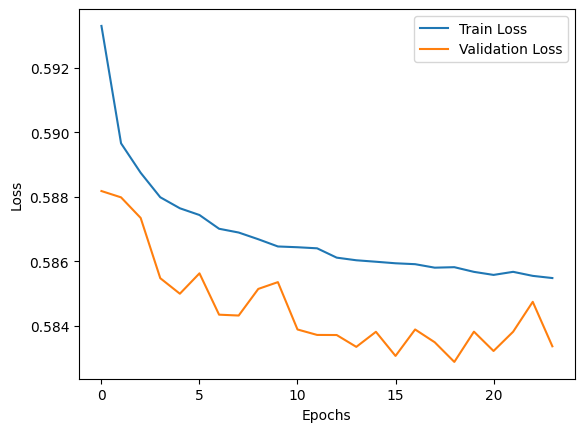

Accuracy: 0.6981
Precision: 0.7117
Recall: 0.9336
F1 Score: 0.8077


In [ ]:
# 학습 데이터와 검증 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# 데이터를 텐서로 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# 데이터 로더 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# TCN 모델 정의
class TCNModel(nn.Module):
    def __init__(self, input_size, num_channels, kernel_size=2, dropout=0.2):
        super(TCNModel, self).__init__()
        self.tcn = nn.Conv1d(input_size, num_channels, kernel_size, padding=kernel_size//2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_channels, 1)

    def forward(self, x):
        x = x.transpose(1, 2)  # (batch_size, seq_len, input_size) -> (batch_size, input_size, seq_len)
        y1 = self.tcn(x)
        y1 = self.relu(y1)
        y1 = self.dropout(y1)
        y1 = y1[:, :, -1]
        o = self.fc(y1)
        return o

# 모델 설정
input_size = X_train.shape[2]
num_channels = 64
model = TCNModel(input_size, num_channels)

# 손실 함수 및 옵티마이저 설정
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 조기 종료 설정
patience = 5
best_loss = float('inf')
patience_counter = 0

# 학습 및 검증 손실을 저장할 리스트
train_losses = []
val_losses = []

# 추가 학습
num_epochs = 100  # 최대 에포크 수
for epoch in range(num_epochs):
    # 학습 단계
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # 검증 단계
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch)
            loss = criterion(output, y_batch)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    # 조기 종료 조건 체크
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("조기 종료 조건 충족. 학습을 중지합니다.")
        break

# 학습 및 검증 손실 시각화
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 모델 평가
model.eval()
with torch.no_grad():
    y_true = []
    y_pred = []
    for X_batch, y_batch in test_loader:
        output = model(X_batch)
        y_true.extend(y_batch.tolist())
        y_pred.extend(torch.sigmoid(output).squeeze().tolist())

# 이진 분류 결과를 위한 평가 지표 계산
y_pred = np.array(y_pred) > 0.5
y_true = y_test_tensor.numpy()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

In [ ]:
pip install xgboost



In [ ]:
from xgboost import XGBClassifier

# 학습 데이터와 검증 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# XGBoost 모델 학습
model = XGBClassifier()
model.fit(X_train, y_train)

# 피처 중요도 평가
feature_importances = model.feature_importances_
feature_names = data.drop(columns=['max_return_60min', 'min_return_60min', 'target']).columns

In [ ]:
# 피처 중요도를 데이터프레임으로 변환
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# 중요도에 따라 정렬
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# 피처 중요도 표 출력
feature_importance_df.head(50)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector

In [ ]:
# 학습 데이터와 검증 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 순차적 전진 선택
model = LogisticRegression(max_iter=10000)
sfs = SequentialFeatureSelector(model, n_features_to_select='auto', direction='forward')
sfs.fit(X_train, y_train)

# 선택된 피처
selected_features = sfs.get_support(indices=True)
selected_feature_names = data.drop(columns=['max_return_60min', 'min_return_60min', 'target']).columns[selected_features]

# 선택된 피처 중요도 (일반적으로 Logistic Regression에서는 coef_ 속성을 사용하여 피처 중요도를 평가할 수 있습니다)
model.fit(sfs.transform(X_train), y_train)
feature_importances = model.coef_[0]

# 선택된 피처 중요도를 데이터프레임으로 변환
feature_importance_df = pd.DataFrame({
    'Feature': selected_feature_names,
    'Importance': feature_importances
})

# 중요도에 따라 정렬
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# 피처 중요도 표 출력
print(feature_importance_df)

# 모델 성능 평가
accuracy = model.score(sfs.transform(X_test), y_test)
print('Model accuracy with selected features:', accuracy)

In [ ]:
# 모델 저장 경로
model_path = '/content/drive/MyDrive/Data/Model/SOL60_SMALLL_INDICATOR3_TCN_v5_180_11.pth'

# 모델 상태 저장
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to /content/drive/MyDrive/Data/Model/SOL60_SMALLL_INDICATOR3_TCN_v5_180_11.pth


In [ ]:
#모델 로드
class TCNModel(nn.Module):
    def __init__(self, input_channels, num_channels, kernel_size=2, dropout=0.2):
        super(TCNModel, self).__init__()
        self.tcn = nn.Conv1d(input_channels, num_channels, kernel_size, padding=kernel_size//2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_channels, 1)

    def forward(self, x):
        x = x.transpose(1, 2)  # (batch_size, seq_len, input_channels) -> (batch_size, input_channels, seq_len)
        y1 = self.tcn(x)
        y1 = self.relu(y1)
        y1 = self.dropout(y1)
        y1 = y1[:, :, -1]
        o = self.fc(y1)
        return o

# 테스트 데이터 텐서로 변환
X_test_tensor = torch.tensor(X_seq, dtype=torch.float32)

# 입력 차원 확인 및 설정
input_channels = X_seq.shape[2]
print(f"Input channels: {input_channels}")

# 모델 설정
num_channels = 64
model = TCNModel(input_channels, num_channels)

# 모델 로드
model_path = '/kaggle/input/lstm_indiactor3/pytorch/tcn_transformer/3/SOL60_SMALLL_INDICATOR3_TCN_v2.pth'
model.load_state_dict(torch.load(model_path))
model.train()  # 모델을 학습 모드로 설정
print(f"Model loaded from {model_path}")

In [ ]:
#추가 학습
# 학습 데이터와 검증 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# 데이터를 텐서로 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# 데이터 로더 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 손실 함수 및 옵티마이저 설정
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 조기 종료 설정
patience = 5
best_loss = float('inf')
patience_counter = 0

# 학습 및 검증 손실을 저장할 리스트
train_losses = []
val_losses = []

# 추가 학습
num_epochs = 100  # 최대 에포크 수
for epoch in range(num_epochs):
    # 학습 단계
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # 검증 단계
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch)
            loss = criterion(output, y_batch)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    # 조기 종료 조건 체크
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("조기 종료 조건 충족. 학습을 중지합니다.")
        break

# 학습 및 검증 손실 시각화
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 모델 평가
model.eval()
with torch.no_grad():
    y_true = []
    y_pred = []
    for X_batch, y_batch in test_loader:
        output = model(X_batch)
        y_true.extend(y_batch.tolist())
        y_pred.extend(torch.sigmoid(output).squeeze().tolist())

# 이진 분류 결과를 위한 평가 지표 계산
y_pred = np.array(y_pred) > 0.5
y_true = y_test_tensor.numpy()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

In [ ]:
# 추가 학습 모델 저장 경로
model_path = '/kaggle/working/SOL60_SMALLL_INDICATOR3_TCN_v3.pth'

# 모델 상태 저장
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

In [ ]:
#모델 로드
class TCNModel(nn.Module):
    def __init__(self, input_channels, num_channels, kernel_size=2, dropout=0.2):
        super(TCNModel, self).__init__()
        self.tcn = nn.Conv1d(input_channels, num_channels, kernel_size, padding=kernel_size//2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_channels, 1)

    def forward(self, x):
        x = x.transpose(1, 2)  # (batch_size, seq_len, input_channels) -> (batch_size, input_channels, seq_len)
        y1 = self.tcn(x)
        y1 = self.relu(y1)
        y1 = self.dropout(y1)
        y1 = y1[:, :, -1]
        o = self.fc(y1)
        return o

# 테스트 데이터 텐서로 변환
X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)

# 입력 차원 확인 및 설정
input_channels = X_test_seq.shape[2]
print(f"Input channels: {input_channels}")

# 모델 설정
num_channels = 64
model = TCNModel(input_channels, num_channels)

# 모델 로드
model_path = '/kaggle/input/lstm_indiactor3/pytorch/tcn_transformer/5/SOL60_SMALLL_INDICATOR3_TCN_v4.pth'
model.load_state_dict(torch.load(model_path))
model.eval()
print(f"Model loaded from {model_path}")

Input channels: 136
Model loaded from /kaggle/input/lstm_indiactor3/pytorch/tcn_transformer/5/SOL60_SMALLL_INDICATOR3_TCN_v4.pth


In [ ]:
# sequence_length를 사용하여 X_test_seq의 shape를 맞춤
X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)

# 예측 수행
model.eval()
with torch.no_grad():
    predictions = torch.sigmoid(model(X_test_tensor)).squeeze().numpy()

# 예측 결과를 이진 분류로 변환 (0 또는 1)
predictions = (predictions > 0.5).astype(int)

# 예측 결과를 데이터프레임에 추가
data_test['prediction_Transformer'] = np.nan  # 예측 결과를 담을 열을 초기화
data_test.iloc[sequence_length - 1:sequence_length - 1 + len(predictions), data_test.columns.get_loc('prediction_Transformer')] = predictions

# 결과 확인
print(data_test[['open_time', 'prediction_Transformer']].head())

                 open_time  prediction_Transformer
219600 2023-12-26 03:00:00                     NaN
219601 2023-12-26 03:01:00                     NaN
219602 2023-12-26 03:02:00                     NaN
219603 2023-12-26 03:03:00                     NaN
219604 2023-12-26 03:04:00                     NaN


In [ ]:
data_test = data_test.dropna(subset=['prediction_Transformer'])
# 결과 출력
data_test.head()

,open_time,open,high,low,close,volume,time,atr_5,atr_10,atr_14,...,volume_ma_20,price_ma_50,volume_ma_50,price_ma_100,volume_ma_100,price_ma_200,volume_ma_200,max_return_60min,min_return_60min,prediction_Transformer
219659,2023-12-26 03:59:00,119.39,119.40,119.21,119.37,2205.60,239,0.255096,0.264981,0.268530,...,3544.0050,118.5698,3688.0316,118.4187,5355.7672,119.01815,4939.48595,1.105805,-0.226187,1.0
219660,2023-12-26 04:00:00,119.37,119.49,119.18,119.30,2670.35,240,0.266077,0.269483,0.271492,...,3443.6540,118.5884,3639.1390,118.4247,5321.0672,119.01600,4894.57285,1.165130,-0.167645,1.0
219661,2023-12-26 04:01:00,119.30,119.38,119.12,119.22,3434.90,241,0.264861,0.268535,0.270671,...,3351.7990,118.6040,3600.5692,118.4286,5310.7998,119.01325,4879.47190,1.233015,-0.100654,1.0
219662,2023-12-26 04:02:00,119.22,119.26,119.10,119.24,4044.31,242,0.243889,0.257681,0.262766,...,3162.5455,118.6220,3598.2706,118.4314,5314.5459,119.01080,4874.29330,1.216035,-0.100637,1.0
219663,2023-12-26 04:03:00,119.23,119.25,119.12,119.20,3278.43,243,0.221111,0.244913,0.253283,...,3124.9565,118.6420,3576.6430,118.4355,5327.2440,119.00860,4857.90700,1.250000,-0.050336,0.0


In [ ]:
#2등분
def extract_last_half(df):
    num_rows = len(df)
    half_size = num_rows // 2
    start_index = half_size
    end_index = num_rows
    last_half = df.iloc[start_index:end_index]
    return last_half

# 데이터프레임 2등분하여 마지막 등분 추출
data_test = extract_last_half(data_test)
data_test.head()

,open_time,open,high,low,close,volume,time,atr_5,atr_10,atr_14,...,volume_ma_20,price_ma_50,volume_ma_50,price_ma_100,volume_ma_100,price_ma_200,volume_ma_200,max_return_60min,min_return_60min,prediction_Transformer
483150,2024-06-26 03:30:00,138.14,138.30,138.06,138.19,19595.997,210,0.234563,0.202587,0.191826,...,4131.56485,138.8536,2515.22608,139.0606,2499.54574,138.08360,2126.463700,0.441421,-0.571677,1.0
483151,2024-06-26 03:31:00,138.20,138.51,138.20,138.42,5197.861,211,0.251651,0.214328,0.200981,...,4320.62180,138.8440,2588.62394,139.0585,2540.27741,138.09205,2150.189290,0.274527,-0.736888,1.0
483152,2024-06-26 03:32:00,138.42,138.73,138.42,138.54,17301.817,212,0.263321,0.223895,0.208768,...,5151.63980,138.8376,2918.01368,139.0565,2690.36196,138.10280,2234.900955,0.187671,-0.822867,1.0
483153,2024-06-26 03:33:00,138.54,138.63,138.13,138.18,10568.431,213,0.310656,0.251506,0.229570,...,5615.13520,138.8260,3117.73996,139.0503,2791.27010,138.11095,2285.585305,0.448690,-0.564481,1.0
483154,2024-06-26 03:34:00,138.18,138.20,137.91,138.01,26248.288,214,0.306525,0.255355,0.233887,...,6888.15545,138.8130,3622.84430,139.0417,3040.07326,138.11820,2415.539085,0.572422,-0.441997,1.0


In [ ]:
#3등분
def extract_last_third(df):
    num_rows = len(df)
    third_size = num_rows // 3
    start_index = 2 * third_size
    end_index = num_rows
    last_third = df.iloc[start_index:end_index]
    return last_third

# 데이터프레임 3등분하여 마지막 등분 추출
data_test = extract_last_third(data_test)
data_test.head()

,open_time,open,high,low,close,volume,time,atr_5,atr_10,atr_14,...,volume_ma_20,price_ma_50,volume_ma_50,price_ma_100,volume_ma_100,price_ma_200,volume_ma_200,max_return_60min,min_return_60min,prediction_Transformer
483139,2024-06-26 03:19:00,138.95,138.95,138.71,138.74,2719.202,199,0.151657,0.151748,0.155117,...,1511.48415,139.0120,1425.68180,139.0481,2052.40292,137.98065,1825.188800,0.043246,-0.965835,1.0
483140,2024-06-26 03:20:00,138.74,138.78,138.67,138.71,1846.202,200,0.143325,0.147573,0.151895,...,1491.30910,139.0056,1411.63308,139.0540,2055.09375,137.99105,1830.676935,0.064884,-0.944416,1.0
483141,2024-06-26 03:21:00,138.71,138.72,138.52,138.57,2041.675,201,0.154660,0.152816,0.155331,...,1547.85235,138.9920,1430.21264,139.0573,2040.37537,138.00145,1832.707110,0.165981,-0.844339,1.0
483142,2024-06-26 03:22:00,138.57,138.59,138.47,138.47,1599.139,202,0.147728,0.149534,0.152807,...,1601.10540,138.9740,1420.61552,139.0590,2035.12914,138.01200,1837.669590,0.238319,-0.772731,1.0
483143,2024-06-26 03:23:00,138.48,138.63,138.47,138.55,1222.658,203,0.150183,0.150581,0.153321,...,1555.28580,138.9618,1422.11902,139.0610,2027.93361,138.02250,1840.550630,0.180440,-0.830025,1.0


In [ ]:
# 4등분하여 마지막 등분을 추출하는 함수
def extract_last_quarter(df):
    num_rows = len(df)
    quarter_size = num_rows // 4
    start_index = 3 * quarter_size
    end_index = num_rows
    last_quarter = df.iloc[start_index:end_index]
    return last_quarter

# 데이터프레임 4등분하여 마지막 등분 추출
data_test = extract_last_quarter(data_test)
data_test.head()

,open_time,open,high,low,close,volume,time,atr_5,atr_10,atr_14,...,volume_ma_20,price_ma_50,volume_ma_50,price_ma_100,volume_ma_100,price_ma_200,volume_ma_200,max_return_60min,min_return_60min,prediction_Transformer
483134,2024-06-26 03:14:00,139.07,139.19,139.06,139.11,787.883,194,0.145700,0.155303,0.159834,...,1380.78415,139.0218,1467.86050,139.0051,2128.10890,137.92030,1803.909785,0.064697,-1.135792,0.0
483135,2024-06-26 03:15:00,139.10,139.20,139.07,139.12,2271.696,195,0.142560,0.152772,0.157703,...,1442.50610,139.0272,1428.01562,139.0171,2128.94605,137.93290,1806.277380,0.057504,-1.142898,0.0
483136,2024-06-26 03:16:00,139.12,139.15,139.09,139.09,521.951,196,0.126048,0.143495,0.150725,...,1405.13840,139.0282,1391.54232,139.0266,2102.59753,137.94545,1806.303700,0.079085,-1.215041,0.0
483137,2024-06-26 03:17:00,139.09,139.20,139.06,139.06,913.991,197,0.128838,0.143146,0.149958,...,1368.73300,139.0260,1385.12526,139.0350,2078.59059,137.95795,1810.017230,0.007191,-1.193729,0.0
483138,2024-06-26 03:18:00,139.07,139.07,138.95,138.96,1514.901,198,0.127071,0.140831,0.147819,...,1407.33635,139.0194,1396.52946,139.0428,2056.14437,137.96985,1815.880925,-0.007196,-1.122625,0.0


In [ ]:
# 5등분하여 마지막 등분을 추출하는 함수
def extract_last_sixth(df):
    num_rows = len(df)
    fifth_size = num_rows // 5
    start_index = 4 * fifth_size
    end_index = num_rows
    last_sixth = df.iloc[start_index:end_index]
    return last_sixth

# 데이터프레임 5등분하여 마지막 등분 추출
data_test = extract_last_sixth(data_test)
data_test.head()

,open_time,open,high,low,close,volume,time,atr_5,atr_10,atr_14,...,volume_ma_20,price_ma_50,volume_ma_50,price_ma_100,volume_ma_100,price_ma_200,volume_ma_200,max_return_60min,min_return_60min,prediction_Transformer
483131,2024-06-26 03:11:00,139.05,139.13,138.93,138.95,1416.722,191,0.181914,0.173844,0.173535,...,1335.52865,139.0306,1538.64206,138.9660,2316.22953,137.88215,1803.644715,0.179921,-1.021950,0.0
483132,2024-06-26 03:12:00,138.95,139.00,138.93,138.99,681.457,192,0.159531,0.163460,0.166139,...,1341.56935,139.0232,1479.77166,138.9813,2307.37870,137.89455,1803.530610,0.151090,-1.050435,0.0
483133,2024-06-26 03:13:00,139.00,139.10,139.00,139.06,1298.523,193,0.149625,0.158114,0.162129,...,1395.76860,139.0202,1495.37404,138.9931,2137.86435,137.90740,1805.054650,0.100676,-1.100244,0.0
483134,2024-06-26 03:14:00,139.07,139.19,139.06,139.11,787.883,194,0.145700,0.155303,0.159834,...,1380.78415,139.0218,1467.86050,139.0051,2128.10890,137.92030,1803.909785,0.064697,-1.135792,0.0
483135,2024-06-26 03:15:00,139.10,139.20,139.07,139.12,2271.696,195,0.142560,0.152772,0.157703,...,1442.50610,139.0272,1428.01562,139.0171,2128.94605,137.93290,1806.277380,0.057504,-1.142898,0.0


In [ ]:
# 6등분하여 마지막 등분을 추출하는 함수
def extract_last_sixth(df):
    num_rows = len(df)
    sixth_size = num_rows // 6
    start_index = 5 * sixth_size
    end_index = num_rows
    last_sixth = df.iloc[start_index:end_index]
    return last_sixth

# 데이터프레임 6등분하여 마지막 등분 추출
data_test = extract_last_sixth(data_test)
data_test.head()

,open_time,open,high,low,close,volume,time,atr_5,atr_10,atr_14,...,volume_ma_20,price_ma_50,volume_ma_50,price_ma_100,volume_ma_100,price_ma_200,volume_ma_200,max_return_60min,min_return_60min,prediction_Transformer
483129,2024-06-26 03:09:00,138.96,139.03,138.81,138.98,1950.582,189,0.171740,0.167709,0.169306,...,1303.42895,139.0496,1553.94752,138.9373,2314.60438,137.85655,1792.737895,0.158296,-0.985753,0.0
483130,2024-06-26 03:10:00,138.99,139.14,138.94,139.04,1982.475,190,0.177392,0.170938,0.171499,...,1341.89890,139.0388,1549.86578,138.9512,2311.96982,137.86955,1799.513395,0.115075,-1.086018,0.0
483131,2024-06-26 03:11:00,139.05,139.13,138.93,138.95,1416.722,191,0.181914,0.173844,0.173535,...,1335.52865,139.0306,1538.64206,138.9660,2316.22953,137.88215,1803.644715,0.179921,-1.021950,0.0
483132,2024-06-26 03:12:00,138.95,139.00,138.93,138.99,681.457,192,0.159531,0.163460,0.166139,...,1341.56935,139.0232,1479.77166,138.9813,2307.37870,137.89455,1803.530610,0.151090,-1.050435,0.0
483133,2024-06-26 03:13:00,139.00,139.10,139.00,139.06,1298.523,193,0.149625,0.158114,0.162129,...,1395.76860,139.0202,1495.37404,138.9931,2137.86435,137.90740,1805.054650,0.100676,-1.100244,0.0


In [ ]:
# 7등분하여 마지막 등분을 추출하는 함수
def extract_last_sixth(df):
    num_rows = len(df)
    sixth_size = num_rows // 7
    start_index = 6 * sixth_size
    end_index = num_rows
    last_sixth = df.iloc[start_index:end_index]
    return last_sixth

# 데이터프레임 6등분하여 마지막 등분 추출
data_test = extract_last_sixth(data_test)
data_test.head()

,open_time,open,high,low,close,volume,time,atr_5,atr_10,atr_14,...,volume_ma_20,price_ma_50,volume_ma_50,price_ma_100,volume_ma_100,price_ma_200,volume_ma_200,max_return_60min,min_return_60min,prediction_Transformer
483125,2024-06-26 03:05:00,138.83,138.89,138.76,138.85,1813.918,185,0.172960,0.168394,0.170713,...,1398.02205,139.1354,1732.27458,138.8868,2296.70916,137.80790,1804.578980,0.252071,-0.828232,0.0
483126,2024-06-26 03:06:00,138.85,138.91,138.77,138.86,1403.495,186,0.166368,0.165555,0.168519,...,1278.59125,139.1104,1701.78430,138.8980,2301.88296,137.81975,1782.116840,0.244851,-0.835374,0.0
483127,2024-06-26 03:07:00,138.86,138.98,138.86,138.97,581.795,187,0.157094,0.160999,0.165054,...,1232.89275,139.0852,1616.46422,138.9111,2297.50881,137.83140,1776.786675,0.165503,-0.913866,0.0
483128,2024-06-26 03:08:00,138.98,139.13,138.96,138.96,2525.596,188,0.159676,0.161899,0.165407,...,1326.04545,139.0614,1602.36816,138.9242,2304.10313,137.84375,1787.504355,0.172712,-0.971503,0.0
483129,2024-06-26 03:09:00,138.96,139.03,138.81,138.98,1950.582,189,0.171740,0.167709,0.169306,...,1303.42895,139.0496,1553.94752,138.9373,2314.60438,137.85655,1792.737895,0.158296,-0.985753,0.0


In [ ]:
#12등분 => 1개월
def extract_last_twelfth(df):
    num_rows = len(df)
    twelfth_size = num_rows // 12
    start_index = 11 * twelfth_size
    end_index = num_rows
    last_twelfth = df.iloc[start_index:end_index]
    return last_twelfth

# 데이터프레임 12등분하여 마지막 등분 추출
data_test = extract_last_twelfth(data_test)
data_test.head()

,open_time,open,high,low,close,volume,time,atr_5,atr_10,atr_14,...,volume_ma_20,price_ma_50,volume_ma_50,price_ma_100,volume_ma_100,price_ma_200,volume_ma_200,max_return_60min,min_return_60min,prediction_Transformer
483124,2024-06-26 03:04:00,138.91,138.96,138.80,138.83,2011.855,184,0.183700,0.172660,0.173845,...,1446.83300,139.1630,1889.52832,138.8753,2303.04817,137.79565,1797.307520,0.266513,-0.813945,0.0
483125,2024-06-26 03:05:00,138.83,138.89,138.76,138.85,1813.918,185,0.172960,0.168394,0.170713,...,1398.02205,139.1354,1732.27458,138.8868,2296.70916,137.80790,1804.578980,0.252071,-0.828232,0.0
483126,2024-06-26 03:06:00,138.85,138.91,138.77,138.86,1403.495,186,0.166368,0.165555,0.168519,...,1278.59125,139.1104,1701.78430,138.8980,2301.88296,137.81975,1782.116840,0.244851,-0.835374,0.0
483127,2024-06-26 03:07:00,138.86,138.98,138.86,138.97,581.795,187,0.157094,0.160999,0.165054,...,1232.89275,139.0852,1616.46422,138.9111,2297.50881,137.83140,1776.786675,0.165503,-0.913866,0.0
483128,2024-06-26 03:08:00,138.98,139.13,138.96,138.96,2525.596,188,0.159676,0.161899,0.165407,...,1326.04545,139.0614,1602.36816,138.9242,2304.10313,137.84375,1787.504355,0.172712,-0.971503,0.0


In [ ]:
# 'max_return_60min' 값이 1 이상이고 'prediction' 값이 0인 데이터의 개수
count_max_return_ge_1_prediction_0 = len(data_test[(data_test['max_return_60min'] >= 1.1) & (data_test['prediction_Transformer'] == 1)])

# 'max_return_60min' 값이 1 미만이고 'prediction' 값이 1인 데이터의 개수
count_max_return_lt_1_prediction_1 = len(data_test[(data_test['max_return_60min'] < 1.1) & (data_test['prediction_Transformer'] == 0)])

print(f"max_return_60min이 1 이상인데 prediction이 0인 데이터의 비율: {count_max_return_ge_1_prediction_0/len(data_test)*100}")
print(f"max_return_60min이 1 미만인데 prediction이 1인 데이터의 비율: {count_max_return_lt_1_prediction_1/len(data_test)*100}")

max_return_60min이 1 이상인데 prediction이 0인 데이터의 비율: 2.122233354586028
max_return_60min이 1 미만인데 prediction이 1인 데이터의 비율: 80.36023317242007


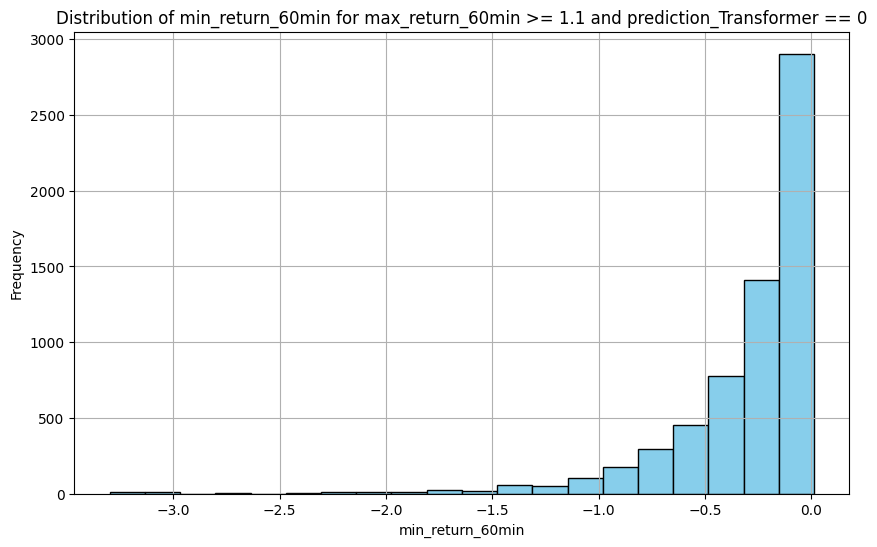

In [ ]:
# 조건을 만족하는 데이터 필터링
filtered_data = data_test[(data_test['max_return_60min'] >= 1.1) & (data_test['prediction_Transformer'] == 0)]

# min_return_60min 값의 분포를 히스토그램으로 시각화
plt.figure(figsize=(10, 6))
plt.hist(filtered_data['min_return_60min'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of min_return_60min for max_return_60min >= 1.1 and prediction_Transformer == 0')
plt.xlabel('min_return_60min')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
# 함수 정의: 각 행에 대해 60행 이내의 high와 low 값을 비교하여 시각을 찾는 함수
def find_high_low_times(df, window=60):
    max_high_times = []
    min_low_times = []

    for i in range(len(df)):
        # 현재 행부터 60행 이내의 데이터를 선택
        subset = df.iloc[i:i+window]

        # 최대 high와 최소 low 값을 찾음
        max_high_idx = subset['high'].idxmax()
        min_low_idx = subset['low'].idxmin()

        # 해당 인덱스의 시간을 저장
        max_high_time = df.at[max_high_idx, 'open_time']
        min_low_time = df.at[min_low_idx, 'open_time']

        max_high_times.append(max_high_time)
        min_low_times.append(min_low_time)

    df['max_high_time'] = max_high_times
    df['min_low_time'] = min_low_times

    return df

# 함수 호출
data_test = find_high_low_times(data_test)
data_test

,open_time,open,high,low,close,volume,time,atr_5,atr_10,atr_14,...,volume_ma_50,price_ma_100,volume_ma_100,price_ma_200,volume_ma_200,max_return_60min,min_return_60min,prediction_Transformer,max_high_time,min_low_time
483131,2024-06-26 03:11:00,139.05,139.13,138.93,138.95,1416.722,191,0.181914,0.173844,0.173535,...,1538.64206,138.9660,2316.22953,137.88215,1803.644715,0.179921,-1.021950,0.0,2024-06-26 03:15:00,2024-06-26 04:10:00
483132,2024-06-26 03:12:00,138.95,139.00,138.93,138.99,681.457,192,0.159531,0.163460,0.166139,...,1479.77166,138.9813,2307.37870,137.89455,1803.530610,0.151090,-1.050435,0.0,2024-06-26 03:15:00,2024-06-26 04:10:00
483133,2024-06-26 03:13:00,139.00,139.10,139.00,139.06,1298.523,193,0.149625,0.158114,0.162129,...,1495.37404,138.9931,2137.86435,137.90740,1805.054650,0.100676,-1.100244,0.0,2024-06-26 03:15:00,2024-06-26 04:10:00
483134,2024-06-26 03:14:00,139.07,139.19,139.06,139.11,787.883,194,0.145700,0.155303,0.159834,...,1467.86050,139.0051,2128.10890,137.92030,1803.909785,0.064697,-1.135792,0.0,2024-06-26 03:15:00,2024-06-26 04:10:00
483135,2024-06-26 03:15:00,139.10,139.20,139.07,139.12,2271.696,195,0.142560,0.152772,0.157703,...,1428.01562,139.0171,2128.94605,137.93290,1806.277380,0.057504,-1.142898,0.0,2024-06-26 03:15:00,2024-06-26 04:10:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527036,2024-07-26 14:56:00,180.23,180.50,180.22,180.50,1473.113,896,0.281338,0.317760,0.338697,...,5298.06338,180.5613,6178.60868,179.55840,3731.289875,0.000000,0.000000,0.0,2024-07-26 14:59:00,2024-07-26 14:56:00
527037,2024-07-26 14:57:00,180.50,180.80,180.50,180.79,4140.400,897,0.285070,0.315984,0.335933,...,5318.99804,180.5875,6216.61879,179.56950,3749.871560,0.000000,0.000000,0.0,2024-07-26 14:59:00,2024-07-26 14:57:00
527038,2024-07-26 14:58:00,180.79,180.96,180.72,180.95,1483.823,898,0.276056,0.308385,0.329081,...,5259.71042,180.6150,6223.40370,179.58160,3747.859670,0.000000,0.000000,0.0,2024-07-26 14:59:00,2024-07-26 15:00:00
527039,2024-07-26 14:59:00,180.96,181.10,180.95,180.98,5323.096,899,0.250845,0.292547,0.316289,...,5280.28360,180.6418,6269.26612,179.59310,3770.414915,0.000000,0.000000,0.0,2024-07-26 14:59:00,2024-07-26 15:00:00


In [ ]:
# 조건에 맞는 새로운 열 추가
def add_condition_column(df):
    # 'max_high_time'과 'min_low_time'이 datetime 형식인지 확인하고 변환
    df['max_high_time'] = pd.to_datetime(df['max_high_time'])
    df['min_low_time'] = pd.to_datetime(df['min_low_time'])

    # 조건에 맞는 행 필터링 (max_return_60min >= 1.1 및 prediction_Transformer == 1)
    filtered_df = df[(df['max_return_60min'] >= 1.1) & (df['prediction_Transformer'] == 1)].copy()

    # 새로운 열 추가 및 초기화
    filtered_df['condition'] = 0

    # 조건을 만족하는 경우 condition 값을 설정
    condition_indices = filtered_df.index[filtered_df['max_high_time'] < filtered_df['min_low_time']]

    filtered_df.loc[condition_indices, 'condition'] = 1

    return filtered_df

# 데이터 타입 변환
data_test['max_high_time'] = pd.to_datetime(data_test['max_high_time'])
data_test['min_low_time'] = pd.to_datetime(data_test['min_low_time'])

# 조건 열 추가
filtered_data_test = add_condition_column(data_test)

# 결과 확인
filtered_data_test

,open_time,open,high,low,close,volume,time,atr_5,atr_10,atr_14,...,price_ma_100,volume_ma_100,price_ma_200,volume_ma_200,max_return_60min,min_return_60min,prediction_Transformer,max_high_time,min_low_time,condition
483980,2024-06-26 17:20:00,134.96,135.14,134.85,134.87,4417.763,1040,0.270998,0.268316,0.261546,...,136.3231,2163.95025,137.05030,2440.313665,1.104768,-0.014829,1.0,2024-06-26 17:59:00,2024-06-26 17:20:00,0
485130,2024-06-27 12:30:00,139.86,140.28,138.73,139.05,13698.206,750,0.501760,0.356028,0.310169,...,139.1960,1998.42575,138.59350,2505.171730,7.270766,-0.381158,1.0,2024-06-27 13:07:00,2024-06-27 12:32:00,0
485131,2024-06-27 12:31:00,139.03,139.35,138.76,138.78,4902.184,751,0.519408,0.379425,0.330157,...,139.1991,2030.04451,138.60470,2516.643960,7.479464,-0.187347,1.0,2024-06-27 13:07:00,2024-06-27 12:32:00,0
485132,2024-06-27 12:32:00,138.79,139.15,138.52,138.96,7817.150,752,0.541526,0.404482,0.351574,...,139.2035,2091.00412,138.61625,2547.615925,7.340242,-0.093552,1.0,2024-06-27 13:07:00,2024-06-27 12:32:00,0
485133,2024-06-27 12:33:00,138.93,139.12,138.93,139.05,3268.285,753,0.471221,0.383034,0.340033,...,139.2092,2116.30722,138.62795,2552.448060,7.270766,-0.158216,1.0,2024-06-27 13:07:00,2024-06-27 12:50:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525917,2024-07-25 20:17:00,166.81,166.88,166.38,166.59,2031.864,1217,0.580069,0.511108,0.480901,...,167.6600,3178.93114,168.95180,3294.618280,2.809292,-0.216099,1.0,2024-07-25 21:15:00,2024-07-25 20:18:00,0
525918,2024-07-25 20:18:00,166.59,166.79,166.23,166.37,2403.481,1218,0.576056,0.515997,0.486551,...,167.6415,3188.46197,168.92905,3301.999550,3.071467,-0.024043,1.0,2024-07-25 21:15:00,2024-07-25 20:18:00,0
525919,2024-07-25 20:19:00,166.37,166.91,166.33,166.81,2743.634,1219,0.576844,0.522397,0.493226,...,167.6286,3206.23359,168.90895,3307.249425,2.799592,-0.035969,1.0,2024-07-25 21:18:00,2024-07-25 20:19:00,0
525920,2024-07-25 20:20:00,166.81,167.16,166.75,167.00,4451.746,1220,0.543476,0.511158,0.487281,...,167.6176,3234.25581,168.89025,3323.641725,2.694611,-0.107784,1.0,2024-07-25 21:18:00,2024-07-25 20:20:00,0


In [ ]:
condition_1_data = filtered_data_test[filtered_data_test['condition'] == 0]
condition_1_data

,open_time,open,high,low,close,volume,time,atr_5,atr_10,atr_14,...,price_ma_100,volume_ma_100,price_ma_200,volume_ma_200,max_return_60min,min_return_60min,prediction_Transformer,max_high_time,min_low_time,condition
483980,2024-06-26 17:20:00,134.96,135.14,134.85,134.87,4417.763,1040,0.270998,0.268316,0.261546,...,136.3231,2163.95025,137.05030,2440.313665,1.104768,-0.014829,1.0,2024-06-26 17:59:00,2024-06-26 17:20:00,0
485130,2024-06-27 12:30:00,139.86,140.28,138.73,139.05,13698.206,750,0.501760,0.356028,0.310169,...,139.1960,1998.42575,138.59350,2505.171730,7.270766,-0.381158,1.0,2024-06-27 13:07:00,2024-06-27 12:32:00,0
485131,2024-06-27 12:31:00,139.03,139.35,138.76,138.78,4902.184,751,0.519408,0.379425,0.330157,...,139.1991,2030.04451,138.60470,2516.643960,7.479464,-0.187347,1.0,2024-06-27 13:07:00,2024-06-27 12:32:00,0
485132,2024-06-27 12:32:00,138.79,139.15,138.52,138.96,7817.150,752,0.541526,0.404482,0.351574,...,139.2035,2091.00412,138.61625,2547.615925,7.340242,-0.093552,1.0,2024-06-27 13:07:00,2024-06-27 12:32:00,0
485133,2024-06-27 12:33:00,138.93,139.12,138.93,139.05,3268.285,753,0.471221,0.383034,0.340033,...,139.2092,2116.30722,138.62795,2552.448060,7.270766,-0.158216,1.0,2024-06-27 13:07:00,2024-06-27 12:50:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525917,2024-07-25 20:17:00,166.81,166.88,166.38,166.59,2031.864,1217,0.580069,0.511108,0.480901,...,167.6600,3178.93114,168.95180,3294.618280,2.809292,-0.216099,1.0,2024-07-25 21:15:00,2024-07-25 20:18:00,0
525918,2024-07-25 20:18:00,166.59,166.79,166.23,166.37,2403.481,1218,0.576056,0.515997,0.486551,...,167.6415,3188.46197,168.92905,3301.999550,3.071467,-0.024043,1.0,2024-07-25 21:15:00,2024-07-25 20:18:00,0
525919,2024-07-25 20:19:00,166.37,166.91,166.33,166.81,2743.634,1219,0.576844,0.522397,0.493226,...,167.6286,3206.23359,168.90895,3307.249425,2.799592,-0.035969,1.0,2024-07-25 21:18:00,2024-07-25 20:19:00,0
525920,2024-07-25 20:20:00,166.81,167.16,166.75,167.00,4451.746,1220,0.543476,0.511158,0.487281,...,167.6176,3234.25581,168.89025,3323.641725,2.694611,-0.107784,1.0,2024-07-25 21:18:00,2024-07-25 20:20:00,0


In [ ]:
# max_high_time과 min_low_time의 차이를 분으로 계산하여 새로운 열 추가
condition_1_data['time_difference_minutes'] = (condition_1_data['max_high_time'] - condition_1_data['min_low_time']).dt.total_seconds() / 60
condition_1_data

/tmp/ipykernel_13/415765311.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  condition_1_data['time_difference_minutes'] = (condition_1_data['max_high_time'] - condition_1_data['min_low_time']).dt.total_seconds() / 60


,open_time,open,high,low,close,volume,time,atr_5,atr_10,atr_14,...,volume_ma_100,price_ma_200,volume_ma_200,max_return_60min,min_return_60min,prediction_Transformer,max_high_time,min_low_time,condition,time_difference_minutes
483980,2024-06-26 17:20:00,134.96,135.14,134.85,134.87,4417.763,1040,0.270998,0.268316,0.261546,...,2163.95025,137.05030,2440.313665,1.104768,-0.014829,1.0,2024-06-26 17:59:00,2024-06-26 17:20:00,0,39.0
485130,2024-06-27 12:30:00,139.86,140.28,138.73,139.05,13698.206,750,0.501760,0.356028,0.310169,...,1998.42575,138.59350,2505.171730,7.270766,-0.381158,1.0,2024-06-27 13:07:00,2024-06-27 12:32:00,0,35.0
485131,2024-06-27 12:31:00,139.03,139.35,138.76,138.78,4902.184,751,0.519408,0.379425,0.330157,...,2030.04451,138.60470,2516.643960,7.479464,-0.187347,1.0,2024-06-27 13:07:00,2024-06-27 12:32:00,0,35.0
485132,2024-06-27 12:32:00,138.79,139.15,138.52,138.96,7817.150,752,0.541526,0.404482,0.351574,...,2091.00412,138.61625,2547.615925,7.340242,-0.093552,1.0,2024-06-27 13:07:00,2024-06-27 12:32:00,0,35.0
485133,2024-06-27 12:33:00,138.93,139.12,138.93,139.05,3268.285,753,0.471221,0.383034,0.340033,...,2116.30722,138.62795,2552.448060,7.270766,-0.158216,1.0,2024-06-27 13:07:00,2024-06-27 12:50:00,0,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525917,2024-07-25 20:17:00,166.81,166.88,166.38,166.59,2031.864,1217,0.580069,0.511108,0.480901,...,3178.93114,168.95180,3294.618280,2.809292,-0.216099,1.0,2024-07-25 21:15:00,2024-07-25 20:18:00,0,57.0
525918,2024-07-25 20:18:00,166.59,166.79,166.23,166.37,2403.481,1218,0.576056,0.515997,0.486551,...,3188.46197,168.92905,3301.999550,3.071467,-0.024043,1.0,2024-07-25 21:15:00,2024-07-25 20:18:00,0,57.0
525919,2024-07-25 20:19:00,166.37,166.91,166.33,166.81,2743.634,1219,0.576844,0.522397,0.493226,...,3206.23359,168.90895,3307.249425,2.799592,-0.035969,1.0,2024-07-25 21:18:00,2024-07-25 20:19:00,0,59.0
525920,2024-07-25 20:20:00,166.81,167.16,166.75,167.00,4451.746,1220,0.543476,0.511158,0.487281,...,3234.25581,168.89025,3323.641725,2.694611,-0.107784,1.0,2024-07-25 21:18:00,2024-07-25 20:20:00,0,58.0


In [ ]:
#min_low_time과 open_time의 차이를 분으로 계산하여 새로운 열 추가
condition_1_data['min_low_open_difference_minutes'] = (condition_1_data['max_high_time'] - condition_1_data['open_time']).dt.total_seconds() / 60
condition_1_data

/tmp/ipykernel_13/589549438.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  condition_1_data['min_low_open_difference_minutes'] = (condition_1_data['max_high_time'] - condition_1_data['open_time']).dt.total_seconds() / 60


,open_time,open,high,low,close,volume,time,atr_5,atr_10,atr_14,...,price_ma_200,volume_ma_200,max_return_60min,min_return_60min,prediction_Transformer,max_high_time,min_low_time,condition,time_difference_minutes,min_low_open_difference_minutes
483980,2024-06-26 17:20:00,134.96,135.14,134.85,134.87,4417.763,1040,0.270998,0.268316,0.261546,...,137.05030,2440.313665,1.104768,-0.014829,1.0,2024-06-26 17:59:00,2024-06-26 17:20:00,0,39.0,39.0
485130,2024-06-27 12:30:00,139.86,140.28,138.73,139.05,13698.206,750,0.501760,0.356028,0.310169,...,138.59350,2505.171730,7.270766,-0.381158,1.0,2024-06-27 13:07:00,2024-06-27 12:32:00,0,35.0,37.0
485131,2024-06-27 12:31:00,139.03,139.35,138.76,138.78,4902.184,751,0.519408,0.379425,0.330157,...,138.60470,2516.643960,7.479464,-0.187347,1.0,2024-06-27 13:07:00,2024-06-27 12:32:00,0,35.0,36.0
485132,2024-06-27 12:32:00,138.79,139.15,138.52,138.96,7817.150,752,0.541526,0.404482,0.351574,...,138.61625,2547.615925,7.340242,-0.093552,1.0,2024-06-27 13:07:00,2024-06-27 12:32:00,0,35.0,35.0
485133,2024-06-27 12:33:00,138.93,139.12,138.93,139.05,3268.285,753,0.471221,0.383034,0.340033,...,138.62795,2552.448060,7.270766,-0.158216,1.0,2024-06-27 13:07:00,2024-06-27 12:50:00,0,17.0,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525917,2024-07-25 20:17:00,166.81,166.88,166.38,166.59,2031.864,1217,0.580069,0.511108,0.480901,...,168.95180,3294.618280,2.809292,-0.216099,1.0,2024-07-25 21:15:00,2024-07-25 20:18:00,0,57.0,58.0
525918,2024-07-25 20:18:00,166.59,166.79,166.23,166.37,2403.481,1218,0.576056,0.515997,0.486551,...,168.92905,3301.999550,3.071467,-0.024043,1.0,2024-07-25 21:15:00,2024-07-25 20:18:00,0,57.0,57.0
525919,2024-07-25 20:19:00,166.37,166.91,166.33,166.81,2743.634,1219,0.576844,0.522397,0.493226,...,168.90895,3307.249425,2.799592,-0.035969,1.0,2024-07-25 21:18:00,2024-07-25 20:19:00,0,59.0,59.0
525920,2024-07-25 20:20:00,166.81,167.16,166.75,167.00,4451.746,1220,0.543476,0.511158,0.487281,...,168.89025,3323.641725,2.694611,-0.107784,1.0,2024-07-25 21:18:00,2024-07-25 20:20:00,0,58.0,58.0


In [ ]:
# time_difference_minutes의 최대, 최소, 최빈, 평균값 계산
time_difference_max = condition_1_data['min_low_open_difference_minutes'].max()
time_difference_min = condition_1_data['min_low_open_difference_minutes'].min()
time_difference_mode = condition_1_data['min_low_open_difference_minutes'].mode()[0]  # 최빈값이 여러 개일 경우 첫 번째 값 선택
time_difference_mean = condition_1_data['min_low_open_difference_minutes'].mean()

# 결과 출력
time_difference_stats = {
    'max': time_difference_max,
    'min': time_difference_min,
    'mode': time_difference_mode, #최빈
    'mean': time_difference_mean # 평균
}

time_difference_stats

{'max': 38.0, 'min': 2.0, 'mode': 9.0, 'mean': 16.849462365591396}

In [ ]:
# min_return_60min이 -1 이하인 행들 필터링
negative_return_data = condition_1_data[condition_1_data['min_return_60min'] <= -1]

# time_difference_minutes의 최대, 최소, 최빈, 평균값 계산
time_difference_max = negative_return_data['time_difference_minutes'].max()
time_difference_min = negative_return_data['time_difference_minutes'].min()
time_difference_mode = negative_return_data['time_difference_minutes'].mode()[0]  # 최빈값이 여러 개일 경우 첫 번째 값 선택
time_difference_mean = negative_return_data['time_difference_minutes'].mean()

# 결과 출력
time_difference_stats = {
    'max': time_difference_max,
    'min': time_difference_min,
    'mode': time_difference_mode,  # 최빈값
    'mean': time_difference_mean   # 평균값
}

time_difference_stats

{'max': 57.0, 'min': 5.0, 'mode': 12.0, 'mean': 25.55851063829787}

LSTM(시계열)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# 학습 데이터와 검증 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# 데이터를 텐서로 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# 데이터 로더 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [ ]:
# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        c0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# 모델 설정
input_size = X_train.shape[2]
hidden_size = 50
num_layers = 2
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# GPU 사용 가능하면 사용
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 손실 함수 및 옵티마이저 설정
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습률 감소 스케줄러 설정
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# 조기 종료 설정
patience = 5
best_loss = float('inf')
patience_counter = 0

# 학습 및 검증 손실을 저장할 리스트
train_losses = []
val_losses = []

# 모델 학습
num_epochs = 100  # 최대 에포크 수
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # 검증 단계
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output, y_batch)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    end_time = time.time()
    epoch_duration = end_time - start_time

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Duration: {epoch_duration:.2f}s')

    # 최적의 모델 저장 및 조기 종료 조건 체크
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_lstm_model.pth')
        print(f"Best model saved with val loss: {best_loss:.4f}")
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("조기 종료 조건 충족. 학습을 중지합니다.")
        break

    # 학습률 감소
    scheduler.step()

# 학습 및 검증 손실 시각화
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 최적의 모델 로드
model.load_state_dict(torch.load('best_lstm_model.pth'))
model.to(device)

# 모델 평가
model.eval()
with torch.no_grad():
    y_true = []
    y_pred = []
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        output = model(X_batch)
        y_true.extend(y_batch.tolist())
        y_pred.extend(torch.sigmoid(output).squeeze().tolist())

# 이진 분류 결과를 위한 평가 지표 계산
y_pred = np.array(y_pred) > 0.5
y_true = y_test_tensor.numpy()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

In [ ]:
# 모델 저장
model_path = '/kaggle/working/SOL60_SMALLL_INDICATOR3_LSTM_v4.pth'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

In [ ]:
import torch
import torch.nn as nn

In [ ]:
# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# 모델 설정
input_dim = data_test_predict_scaled.shape[2]  # 예: feature 개수
hidden_dim = 64
num_layers = 2
output_dim = 1

model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)

# 모델 로드
model_path = '/kaggle/working/SOL60_SMALLL_INDICATOR3_LSTM.pth'
model.load_state_dict(torch.load(model_path))
model.eval()

In [ ]:
# 데이터 텐서로 변환
X_test_tensor = torch.tensor(data_test_predict_scaled, dtype=torch.float32)

# 예측 수행
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).cpu().numpy()

# 예측 결과를 이진 분류로 변환 (필요에 따라)
predictions = (predictions > 0.5).astype(int)  # 이진 분류일 경우

# 예측 결과를 데이터프레임에 추가
data_test['prediction_LSTM'] = np.nan  # 예측 결과를 담을 열을 초기화
data_test.iloc[sequence_length - 1:sequence_length - 1 + len(predictions), data_test.columns.get_loc('prediction_LSTM')] = predictions

# 결과 확인
print(data_test[['open_time', 'prediction_LSTM']].head())

In [ ]:
data_test_non_nan = data_test.dropna(subset=['prediction_LSTM'])

# max_return_60min 기준으로 내림차순 정렬
data_test_sorted = data_test_non_nan.sort_values(by='max_return_60min', ascending=False)

# 결과 출력
data_test_sorted

In [ ]:
# 'max_return_60min' 값이 1 이상이고 'prediction' 값이 0인 데이터의 개수
count_max_return_ge_1_prediction_0 = len(data_test[(data_test['max_return_60min'] >= 1.2) & (data_test['prediction_LSTM'] == 1)])

# 'max_return_60min' 값이 1 미만이고 'prediction' 값이 1인 데이터의 개수
count_max_return_lt_1_prediction_1 = len(data_test[(data_test['max_return_60min'] < 1.2) & (data_test['prediction_LSTM'] == 0)])

print(f"max_return_60min이 1 이상인데 prediction이 0인 데이터의 비율: {count_max_return_ge_1_prediction_0/len(data_test)*100}")
print(f"max_return_60min이 1 미만인데 prediction이 1인 데이터의 비율: {count_max_return_lt_1_prediction_1/len(data_test)*100}")

Transformer

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# 학습 데이터와 검증 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [ ]:
# 데이터를 텐서로 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# 데이터 로더 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.9 MB/s eta 0:00:00


In [ ]:
from tqdm.notebook import tqdm

In [ ]:
# TransformerEncoder 모델 정의
class TransformerEncoderModel(nn.Module):
    def __init__(self, input_dim, nhead, num_layers, dim_feedforward, output_dim):
        super(TransformerEncoderModel, self).__init__()
        self.embedding = nn.Linear(input_dim, input_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=nhead, dim_feedforward=dim_feedforward, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, src):
        src = self.embedding(src)
        output = self.transformer_encoder(src)
        output = self.fc(output[:, -1, :])  # Use the output from the last time step
        return output

# 입력 차원 확인 및 설정
input_dim = X_train.shape[2]
print(f"Input dimension: {input_dim}")

# 모델 설정 (로드할 때 필요)
nhead = 2
num_layers = 2
dim_feedforward = 64
output_dim = 1

model = TransformerEncoderModel(input_dim, nhead, num_layers, dim_feedforward, output_dim)

# 모델 로드
model_path = '/content/drive/MyDrive/Data/Model/SOL60_SMALLL_INDICATOR3_Transformer_v2.pth'
model.load_state_dict(torch.load(model_path))
model.train()  # 추가 학습을 위해 학습 모드로 전환
print(f"Model loaded from {model_path}")

Input dimension: 136
Model loaded from /content/drive/MyDrive/Data/Model/SOL60_SMALLL_INDICATOR3_Transformer_v2.pth


In [ ]:
#추가학습

# 손실 함수 및 옵티마이저 설정
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 조기 종료 설정
patience = 5
best_loss = float('inf')
patience_counter = 0

# 학습 및 검증 손실을 저장할 리스트
train_losses = []
val_losses = []

# 추가 학습
num_epochs = 100  # 최대 에포크 수
for epoch in range(num_epochs):
    # 학습 단계
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # 검증 단계
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch)
            loss = criterion(output, y_batch)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    # 조기 종료 조건 체크
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("조기 종료 조건 충족. 학습을 중지합니다.")
        break

# 학습 및 검증 손실 시각화
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 모델 평가
model.eval()
with torch.no_grad():
    y_true = []
    y_pred = []
    for X_batch, y_batch in test_loader:
        output = model(X_batch)
        y_true.extend(y_batch.tolist())
        y_pred.extend(torch.sigmoid(output).squeeze().tolist())

# 이진 분류 결과를 위한 평가 지표 계산
y_pred = np.array(y_pred) > 0.5
y_true = y_test_tensor.numpy()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Epoch [1/100], Train Loss: 0.4347, Val Loss: 0.4326
Epoch [2/100], Train Loss: 0.4328, Val Loss: 0.4310
Epoch [3/100], Train Loss: 0.4320, Val Loss: 0.4299
Epoch [4/100], Train Loss: 0.4316, Val Loss: 0.4329
Epoch [5/100], Train Loss: 0.4322, Val Loss: 0.4288
Epoch [6/100], Train Loss: 0.4314, Val Loss: 0.4288
Epoch [7/100], Train Loss: 0.4325, Val Loss: 0.4306
Epoch [8/100], Train Loss: 0.4308, Val Loss: 0.4300
Epoch [9/100], Train Loss: 0.4315, Val Loss: 0.4305


KeyboardInterrupt: 

In [ ]:
#2nd Account
# 모델 저장 경로
model_path = '/content/drive/MyDrive/Data/Model/SOL60_SMALLL_INDICATOR3_Transformer_v3.pth'

# 모델 상태 저장
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to /content/drive/MyDrive/Data/Model/SOL60_SMALLL_INDICATOR3_Transformer_v3.pth


In [ ]:
# 모델 평가
model.eval()
with torch.no_grad():
    y_true = []
    y_pred = []
    for X_batch, y_batch in test_loader:
        output = model(X_batch)
        y_true.extend(y_batch.tolist())
        y_pred.extend(torch.sigmoid(output).squeeze().tolist())

# 이진 분류 결과를 위한 평가 지표 계산
y_pred = np.array(y_pred) > 0.5
y_true = y_test_tensor.numpy()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

In [ ]:
X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)

# 모델 정의 (로드할 때 필요)
class TransformerEncoderModel(nn.Module):
    def __init__(self, input_dim, nhead, num_layers, dim_feedforward, output_dim):
        super(TransformerEncoderModel, self).__init__()
        self.embedding = nn.Linear(input_dim, input_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=nhead, dim_feedforward=dim_feedforward, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, src):
        src = self.embedding(src)
        output = self.transformer_encoder(src)
        output = self.fc(output[:, -1, :])  # Use the output from the last time step
        return output

# 입력 차원 확인 및 설정
input_dim = X_test_seq.shape[2]
print(f"Input dimension: {input_dim}")

# 모델 설정 (로드할 때 필요)
nhead = 2
num_layers = 2
dim_feedforward = 64
output_dim = 1

model = TransformerEncoderModel(input_dim, nhead, num_layers, dim_feedforward, output_dim)

# 모델 로드
model_path = '/content/drive/MyDrive/Data/Model/SOL60_SMALLL_INDICATOR3_Transformer_v2.pth'
model.load_state_dict(torch.load(model_path))
model.eval()
print(f"Model loaded from {model_path}")

Input dimension: 136
Model loaded from /content/drive/MyDrive/Data/Model/SOL60_SMALLL_INDICATOR3_Transformer_v2.pth


In [ ]:
# sequence_length를 사용하여 X_test_seq의 shape를 맞춤
sequence_length = X_test_seq.shape[1]
X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32).view(-1, sequence_length, input_dim)

# 예측 수행
with torch.no_grad():
    predictions = torch.sigmoid(model(X_test_tensor)).squeeze().numpy()

# 예측 결과를 이진 분류로 변환 (0 또는 1)
predictions = (predictions > 0.5).astype(int)

# 예측 결과를 데이터프레임에 추가
data_test['prediction_Transformer'] = np.nan  # 예측 결과를 담을 열을 초기화
data_test.iloc[sequence_length - 1:sequence_length - 1 + len(predictions), data_test.columns.get_loc('prediction_Transformer')] = predictions

# 결과 확인
print(data_test[['open_time', 'prediction_Transformer']].head())

                 open_time  prediction_Transformer
219600 2023-12-26 03:00:00                     NaN
219601 2023-12-26 03:01:00                     NaN
219602 2023-12-26 03:02:00                     NaN
219603 2023-12-26 03:03:00                     NaN
219604 2023-12-26 03:04:00                     NaN


In [ ]:
data_test_non_nan = data_test.dropna(subset=['prediction_Transformer'])

# max_return_60min 기준으로 내림차순 정렬
data_test_sorted = data_test_non_nan.sort_values(by='max_return_60min', ascending=False)

# 결과 출력
data_test_sorted

,open_time,open,high,low,close,volume,time,atr_5,atr_10,atr_14,...,volume_ma_20,price_ma_50,volume_ma_50,price_ma_100,volume_ma_100,price_ma_200,volume_ma_200,max_return_60min,min_return_60min,prediction_Transformer
231669,2024-01-03 12:09:00,92.17,92.94,85.27,85.53,109929.43,729,3.526993,2.391708,1.946489,...,42466.8325,103.1152,24053.5672,105.1005,17516.8163,106.96175,11423.87535,17.701391,-0.619666,1.0
321416,2024-03-05 19:56:00,117.25,119.00,109.00,109.34,110021.08,1196,4.499693,3.000784,2.468256,...,48219.6985,128.5142,27685.3074,130.6020,17862.9860,131.59270,17659.76055,12.996159,-3.969270,1.0
231670,2024-01-03 12:10:00,85.53,90.22,85.00,89.87,80984.66,730,3.865595,2.674537,2.180311,...,45653.9050,102.8010,25584.9910,104.9152,18212.1532,106.87145,11821.10850,12.017358,-0.389451,1.0
377693,2024-04-13 21:53:00,127.64,128.12,127.57,128.06,8397.33,1313,0.663720,0.776110,0.860010,...,11663.0650,127.2224,20182.7966,126.7163,32449.9798,132.82135,28034.81340,10.885522,0.015618,1.0
377692,2024-04-13 21:52:00,127.14,127.71,127.07,127.64,7966.32,1312,0.692150,0.801233,0.883857,...,11943.2635,127.2300,20663.1456,126.6829,33001.1616,132.87555,28145.95815,10.466938,-0.054842,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251544,2024-01-17 07:24:00,98.65,98.68,98.52,98.56,1950.14,444,0.148926,0.142635,0.141156,...,1720.9105,98.5432,1464.6530,98.4454,2681.7894,98.96390,2542.07645,-0.030438,-2.090097,0.0
247186,2024-01-14 06:46:00,98.32,98.48,98.32,98.48,1913.41,406,0.147321,0.160725,0.166650,...,2688.1105,98.1554,3053.7618,97.8324,3546.5437,97.09395,3426.97175,-0.030463,-1.198213,0.0
277406,2024-02-04 06:26:00,97.54,97.57,97.49,97.49,724.00,386,0.091431,0.086178,0.085420,...,1355.2445,97.6740,1107.0864,97.6508,1506.8362,97.84440,1415.76480,-0.030772,-1.210381,0.0
263528,2024-01-25 15:08:00,87.81,88.07,87.80,87.98,1551.08,908,0.156002,0.154296,0.158920,...,1965.9305,87.8384,3387.1136,87.4378,2952.7823,87.58225,3361.44375,-0.034099,-2.239145,1.0


In [ ]:
# 데이터프레임에서 특정 시간 범위의 데이터를 추출하는 함수
def extract_time_range(df, start_time, end_time):
    # 'open_time' 열을 datetime 형식으로 변환
    df['open_time'] = pd.to_datetime(df['open_time'])

    # 시간 인덱스 설정
    df = df.set_index('open_time')

    # 시간 범위 추출
    if start_time <= end_time:
        result = df.between_time(start_time, end_time)
    else:
        # 시간 범위가 날짜를 걸치는 경우 두 번 추출 후 결합
        result = pd.concat([
            df.between_time(start_time, '23:59'),
            df.between_time('00:00', end_time)
        ])

    return result

result = extract_time_range(data_test, '22:45', '00:15')

In [ ]:
# 'max_return_60min' 값이 1 이상이고 'prediction' 값이 0인 데이터의 개수
count_max_return_ge_1_prediction_0 = len(result[(result['max_return_60min'] >= 1.1) & (result['prediction_Transformer'] == 1)])

# 'max_return_60min' 값이 1 미만이고 'prediction' 값이 1인 데이터의 개수
count_max_return_lt_1_prediction_1 = len(result[(result['max_return_60min'] < 1.1) & (result['prediction_Transformer'] == 0)])

print(f"max_return_60min이 1 이상인데 prediction이 0인 데이터의 비율: {count_max_return_ge_1_prediction_0/len(result)*100}")
print(f"max_return_60min이 1 미만인데 prediction이 1인 데이터의 비율: {count_max_return_lt_1_prediction_1/len(result)*100}")

max_return_60min이 1 이상인데 prediction이 0인 데이터의 비율: 5.055976886962803
max_return_60min이 1 미만인데 prediction이 1인 데이터의 비율: 74.50859000154774


In [ ]:
# 'max_return_60min' 값이 1 이상이고 'prediction' 값이 0인 데이터의 개수
count_max_return_ge_1_prediction_0 = len(data_test[(data_test['max_return_60min'] >= 1.1) & (data_test['prediction_Transformer'] == 1)])

# 'max_return_60min' 값이 1 미만이고 'prediction' 값이 1인 데이터의 개수
count_max_return_lt_1_prediction_1 = len(data_test[(data_test['max_return_60min'] < 1.1) & (data_test['prediction_Transformer'] == 0)])

print(f"max_return_60min이 1 이상인데 prediction이 0인 데이터의 비율: {count_max_return_ge_1_prediction_0/len(data_test)*100}")
print(f"max_return_60min이 1 미만인데 prediction이 1인 데이터의 비율: {count_max_return_lt_1_prediction_1/len(data_test)*100}")

max_return_60min이 1 이상인데 prediction이 0인 데이터의 비율: 3.8949457538488392
max_return_60min이 1 미만인데 prediction이 1인 데이터의 비율: 77.62227678249552


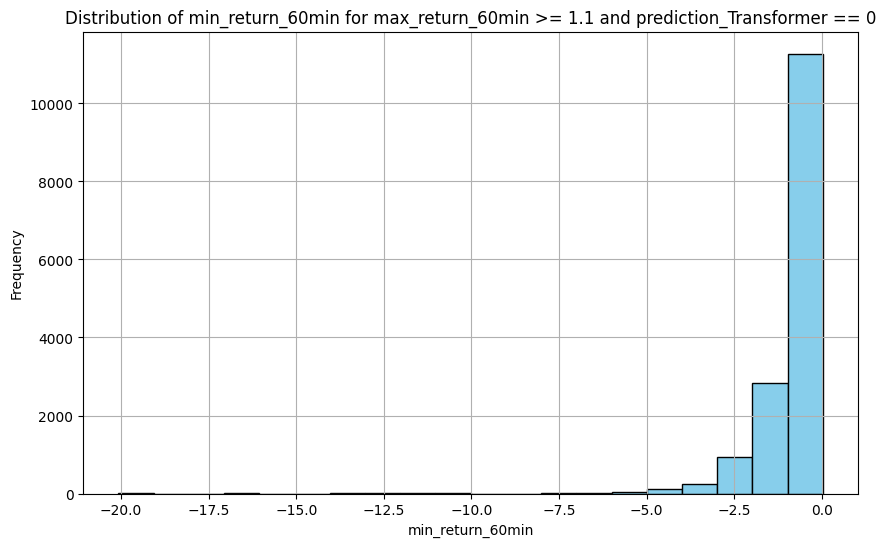

In [ ]:
# 조건을 만족하는 데이터 필터링
filtered_data = data_test[(data_test['max_return_60min'] >= 1.1) & (data_test['prediction_Transformer'] == 1)]

# min_return_60min 값의 분포를 히스토그램으로 시각화
plt.figure(figsize=(10, 6))
plt.hist(filtered_data['min_return_60min'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of min_return_60min for max_return_60min >= 1.1 and prediction_Transformer == 0')
plt.xlabel('min_return_60min')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
# TransformerEncoder 모델 정의
class TransformerEncoderModel(nn.Module):
    def __init__(self, input_dim, nhead, num_layers, dim_feedforward, output_dim):
        super(TransformerEncoderModel, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=nhead, dim_feedforward=dim_feedforward, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, src):
        output = self.transformer_encoder(src)
        output = self.fc(output[:, -1, :])
        return output

def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        xm.optimizer_step(optimizer)
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    return avg_train_loss

def validate_model(model, test_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output, y_batch)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(test_loader)
    return avg_val_loss

def _mp_fn(rank, flags):
    # 데이터 로더 생성
    train_loader = pl.MpDeviceLoader(train_dataset, xm.xla_device())
    test_loader = pl.MpDeviceLoader(test_dataset, xm.xla_device())

    input_dim = X_train.shape[2]
    nhead = 2
    num_layers = 2
    dim_feedforward = 64
    output_dim = 1

    model = TransformerEncoderModel(input_dim, nhead, num_layers, dim_feedforward, output_dim).to(xm.xla_device())
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    patience = 5
    best_val_loss = float('inf')
    patience_counter = 0

    train_losses = []
    val_losses = []

    num_epochs = 50
    print_freq = 5

    for epoch in range(num_epochs):
        start_time = time.time()

        avg_train_loss = train_model(model, train_loader, criterion, optimizer, xm.xla_device())
        train_losses.append(avg_train_loss)

        avg_val_loss = validate_model(model, test_loader, criterion, xm.xla_device())
        val_losses.append(avg_val_loss)

        end_time = time.time()
        epoch_duration = end_time - start_time

        if (epoch + 1) % print_freq == 0 or epoch == num_epochs - 1:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Duration: {epoch_duration:.2f}s')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            xm.save(model.state_dict(), 'best_transformer_model.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("조기 종료 조건 충족. 학습을 중지합니다.")
            break

        scheduler.step()

    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('training_validation_loss.png')  # 학습 곡선 저장
    plt.show()

    # 모델을 반환하기 위해 로드하고 저장 경로 설정
    model.load_state_dict(torch.load('best_transformer_model.pth'))
    model.to(xm.xla_device())

    model.eval()
    with torch.no_grad():
        y_true = []
        y_pred = []
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(xm.xla_device()), y_batch.to(xm.xla_device())
            output = model(X_batch)
            y_true.extend(y_batch.tolist())
            y_pred.extend(torch.sigmoid(output).squeeze().tolist())

    y_pred = np.array(y_pred) > 0.5
    y_true = y_test_tensor.numpy()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # 혼동 행렬 시각화
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')  # 혼동 행렬 저장
    plt.show()

    # 모델 저장 경로
    model_path = '/kaggle/working/SOL60_SMALLL_INDICATOR3_Transformer_v4.pth'
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

    return model  # 모델 반환

FLAGS = {}
model = xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=1, start_method='fork')

In [ ]:
#2nd Account
# 모델 저장 경로
model_path = '/kaggle/working/SOL60_SMALLL_INDICATOR3_Transformer_v4.pth'

# 모델 상태 저장
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

시간대 분석

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

In [ ]:
#메인 데이터
data = pd.read_csv("/kaggle/input/indicator3-full/SOL60_INDICATOR3")

# Display the first few rows of the dataset to ensure it is loaded correctly
data.head()

,Unnamed: 0.1,Unnamed: 0,open_time,open,high,low,close,volume,time,atr_5,...,price_ma_10,volume_ma_10,price_ma_20,volume_ma_20,price_ma_50,volume_ma_50,price_ma_100,volume_ma_100,price_ma_200,volume_ma_200
0,0,0,2020-12-31 15:00:00,1.4458,1.4458,1.4444,1.4456,161.34,15:00,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2020-12-31 15:01:00,1.4477,1.4478,1.4463,1.4463,148.86,15:01,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,2020-12-31 15:02:00,1.4479,1.4530,1.4466,1.4484,3208.13,15:02,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,2020-12-31 15:03:00,1.4503,1.4559,1.4503,1.4558,1639.76,15:03,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,2020-12-31 15:04:00,1.4558,1.4569,1.4545,1.4569,900.91,15:04,0.00404,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# 시간 관련 열 변환 함수
def convert_time_features(data):
    # open_time 열이 datetime 형식이 아닌 경우 변환
    if not np.issubdtype(data['open_time'].dtype, np.datetime64):
        data['open_time'] = pd.to_datetime(data['open_time'])

    # time 열을 분 단위로 변환
    data['time'] = data['open_time'].dt.hour * 60 + data['open_time'].dt.minute

    # 사용하지 않을 열 제외
    data = data.drop(columns=['open_time', 'Unnamed: 0', 'Unnamed: 0.1'])

    return data
# 시간 관련 열 변환
data = convert_time_features(data)
data.head()

,open,high,low,close,volume,time,atr_5,atr_10,atr_14,atr_20,...,price_ma_10,volume_ma_10,price_ma_20,volume_ma_20,price_ma_50,volume_ma_50,price_ma_100,volume_ma_100,price_ma_200,volume_ma_200
0,1.4458,1.4458,1.4444,1.4456,161.34,900,0.00000,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.4477,1.4478,1.4463,1.4463,148.86,901,0.00000,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.4479,1.4530,1.4466,1.4484,3208.13,902,0.00000,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.4503,1.4559,1.4503,1.4558,1639.76,903,0.00000,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.4558,1.4569,1.4545,1.4569,900.91,904,0.00404,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# 무한대 값을 NaN으로 대체
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# NaN 값을 평균으로 대체
imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(data)

# numpy 배열을 다시 DataFrame으로 변환
data = pd.DataFrame(data_imputed, columns=data.columns)

data.head()

,open,high,low,close,volume,time,atr_5,atr_10,atr_14,atr_20,...,price_ma_10,volume_ma_10,price_ma_20,volume_ma_20,price_ma_50,volume_ma_50,price_ma_100,volume_ma_100,price_ma_200,volume_ma_200
0,1.4458,1.4458,1.4444,1.4456,161.34,900.0,0.00000,0.0,0.0,0.0,...,68.323764,3369.7907,68.323751,3369.803441,68.323714,3369.844991,68.323652,3369.908842,68.32352,3370.005505
1,1.4477,1.4478,1.4463,1.4463,148.86,901.0,0.00000,0.0,0.0,0.0,...,68.323764,3369.7907,68.323751,3369.803441,68.323714,3369.844991,68.323652,3369.908842,68.32352,3370.005505
2,1.4479,1.4530,1.4466,1.4484,3208.13,902.0,0.00000,0.0,0.0,0.0,...,68.323764,3369.7907,68.323751,3369.803441,68.323714,3369.844991,68.323652,3369.908842,68.32352,3370.005505
3,1.4503,1.4559,1.4503,1.4558,1639.76,903.0,0.00000,0.0,0.0,0.0,...,68.323764,3369.7907,68.323751,3369.803441,68.323714,3369.844991,68.323652,3369.908842,68.32352,3370.005505
4,1.4558,1.4569,1.4545,1.4569,900.91,904.0,0.00404,0.0,0.0,0.0,...,68.323764,3369.7907,68.323751,3369.803441,68.323714,3369.844991,68.323652,3369.908842,68.32352,3370.005505


In [ ]:
# time 열을 기준으로 그룹화하여 필요한 계산 수행
results = data.groupby('time').agg(
    total_rows=('max_return_60min', 'size'),
    count_above_1_1=('max_return_60min', lambda x: (x >= 1.1).sum())
)

# 비율 계산
results['percentage_above_1_1'] = (results['count_above_1_1'] / results['total_rows']) * 100

# 결과 출력
results = results.reset_index()

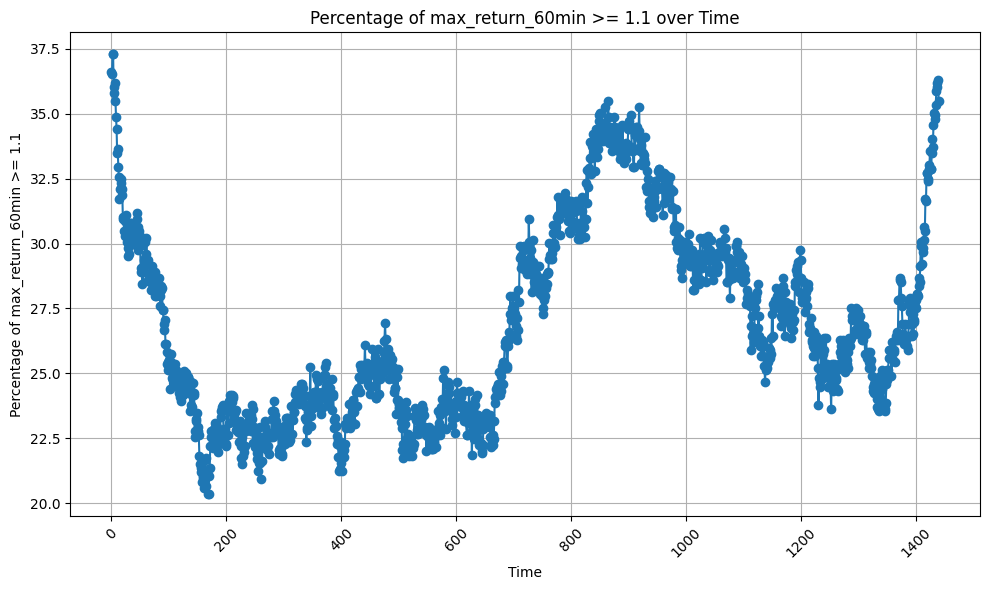

In [ ]:
# 시각화
plt.figure(figsize=(10, 6))
plt.plot(results['time'], results['percentage_above_1_1'], marker='o', linestyle='-')
plt.title('Percentage of max_return_60min >= 1.1 over Time')
plt.xlabel('Time')
plt.ylabel('Percentage of max_return_60min >= 1.1')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

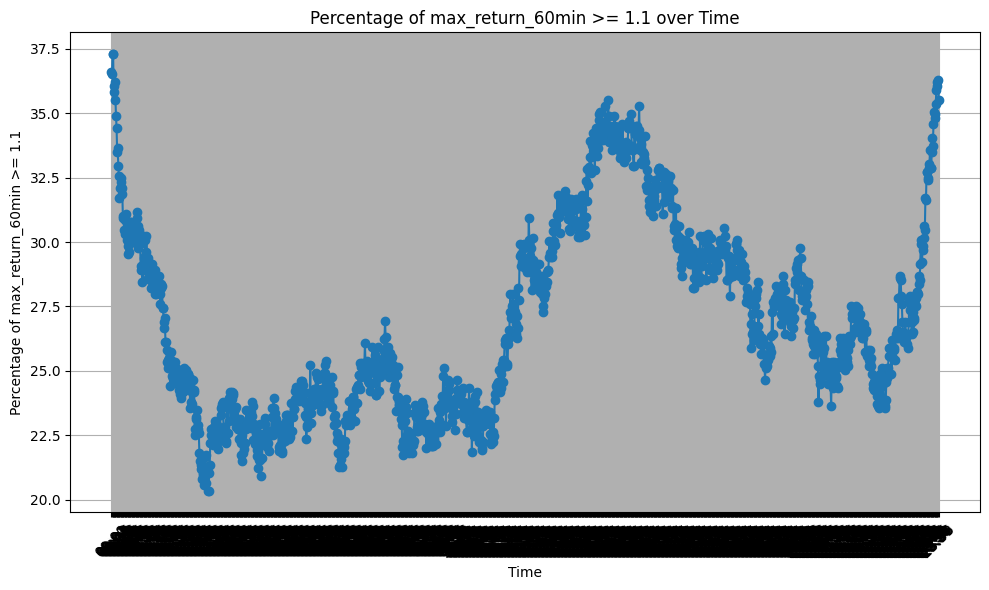

In [ ]:
# time 값을 시-분 형식으로 변환하는 함수
def convert_minutes_to_time(minutes):
    hours = minutes // 60
    mins = minutes % 60
    return f"{int(hours):02}:{int(mins):02}"

# time 열을 기준으로 그룹화하여 필요한 계산 수행
results = data.groupby('time').agg(
    total_rows=('max_return_60min', 'size'),
    count_above_1_1=('max_return_60min', lambda x: (x >= 1.1).sum())
)

# 비율 계산
results['percentage_above_1_1'] = (results['count_above_1_1'] / results['total_rows']) * 100

# time 값을 시-분 형식으로 변환
results = results.reset_index()
results['time'] = results['time'].apply(convert_minutes_to_time)

/tmp/ipykernel_13/1051930311.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_prob_zones['group'] = (high_prob_zones['time'].diff() > 10).cumsum()


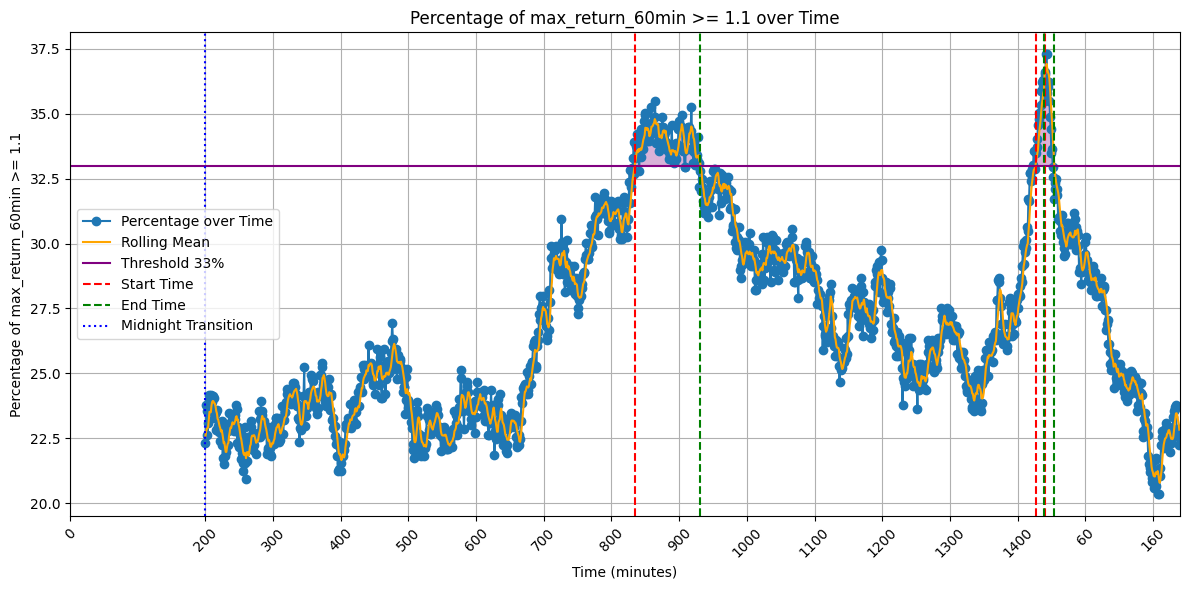

High probability zones above 33% (start_time, end_time):
Start: 00:00 (KST: 09:00), End: 00:14 (KST: 09:14)
Start: 13:55 (KST: 22:55), End: 15:31 (KST: 00:31)
Start: 23:47 (KST: 08:47), End: 23:59 (KST: 08:59)


In [ ]:
# time 열을 기준으로 그룹화하여 필요한 계산 수행
results = data.groupby('time').agg(
    total_rows=('max_return_60min', 'size'),
    count_above_1_1=('max_return_60min', lambda x: (x >= 1.1).sum())
)

# 비율 계산
results['percentage_above_1_1'] = (results['count_above_1_1'] / results['total_rows']) * 100

# 결과 출력
results = results.reset_index()

# 슬라이딩 윈도우의 크기 설정 (예: 60분)
window_size = 60

# 슬라이딩 윈도우 평균 계산
results['rolling_mean'] = results['percentage_above_1_1'].rolling(window=window_size // 10, min_periods=1).mean()

# 임계값 설정
threshold = 33  # 여기서 임계값을 설정하세요

# 임계값 이상의 구간 필터링
high_prob_zones = results[results['rolling_mean'] >= threshold]

# 연속된 구간의 시작과 끝을 식별
high_prob_zones['group'] = (high_prob_zones['time'].diff() > 10).cumsum()

# 각 그룹의 시작과 끝 시간 구하기
grouped_zones = high_prob_zones.groupby('group').agg(
    start_time=('time', 'first'),
    end_time=('time', 'last')
).reset_index()

# 시간축 이동
shift_point = 200
before_shift = results[results['time'] < shift_point].copy()
after_shift = results[results['time'] >= shift_point].copy()

before_shift['shifted_time'] = before_shift['time'] + 1440
after_shift['shifted_time'] = after_shift['time']

results_shifted = pd.concat([after_shift, before_shift]).reset_index(drop=True)

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(results_shifted['shifted_time'], results_shifted['percentage_above_1_1'], marker='o', linestyle='-', label='Percentage over Time')
plt.plot(results_shifted['shifted_time'], results_shifted['rolling_mean'], linestyle='-', color='orange', label='Rolling Mean')

# 임계값 선 추가
plt.axhline(y=threshold, color='purple', linestyle='-', label=f'Threshold {threshold}%')

# 영역 색칠
plt.fill_between(results_shifted['shifted_time'], threshold, results_shifted['percentage_above_1_1'], where=(results_shifted['percentage_above_1_1'] >= threshold), interpolate=True, color='purple', alpha=0.3)

# 높은 확률 구간에서 시작과 끝 구간만 표시
for _, row in grouped_zones.iterrows():
    if row['start_time'] < shift_point:
        shifted_start_time = row['start_time'] + 1440
    else:
        shifted_start_time = row['start_time']
    if row['end_time'] < shift_point:
        shifted_end_time = row['end_time'] + 1440
    else:
        shifted_end_time = row['end_time']
    plt.axvline(x=shifted_start_time, color='red', linestyle='--', label='Start Time' if row['start_time'] == grouped_zones['start_time'].iloc[0] else "")
    plt.axvline(x=shifted_end_time, color='green', linestyle='--', label='End Time' if row['end_time'] == grouped_zones['end_time'].iloc[0] else "")

# 0 지점을 나타내는 세로선 추가
plt.axvline(x=shift_point, color='blue', linestyle=':', label='Midnight Transition')

plt.title('Percentage of max_return_60min >= 1.1 over Time')
plt.xlabel('Time (minutes)')
plt.ylabel('Percentage of max_return_60min >= 1.1')
plt.xticks(rotation=45)
plt.xlim(shift_point, 1440 + shift_point)
plt.xticks(np.arange(shift_point, 1440 + shift_point + 1, 100), labels=[str(x % 1440) for x in np.arange(shift_point, 1440 + shift_point + 1, 100)])
plt.xticks(list(plt.xticks()[0]) + [0], labels=list(plt.xticks()[1]) + ['0'])  # 0을 x축에 추가
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 분을 시-분 형식으로 변환하는 함수
def convert_minutes_to_time(minutes):
    hours = minutes // 60
    mins = minutes % 60
    return f"{int(hours):02}:{int(mins):02}"

# 한국 시간으로 변환하는 함수
def convert_to_kst(utc_minutes):
    kst_minutes = (utc_minutes + 540) % 1440  # 한국 시간은 UTC+9 (540분)
    return convert_minutes_to_time(kst_minutes)

# 높은 확률 구간 시작과 끝 값 출력
print(f"High probability zones above {threshold}% (start_time, end_time):")
for _, row in grouped_zones.iterrows():
    start_time_utc = convert_minutes_to_time(row['start_time'])
    end_time_utc = convert_minutes_to_time(row['end_time'])
    start_time_kst = convert_to_kst(row['start_time'])
    end_time_kst = convert_to_kst(row['end_time'])
    print(f"Start: {start_time_utc} (KST: {start_time_kst}), End: {end_time_utc} (KST: {end_time_kst})")

요일분석

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

In [ ]:
#메인 데이터
data = pd.read_csv("/kaggle/input/indicator3-full/SOL60_INDICATOR3")

# Display the first few rows of the dataset to ensure it is loaded correctly
data.head()

,Unnamed: 0.1,Unnamed: 0,open_time,open,high,low,close,volume,time,atr_5,...,price_ma_10,volume_ma_10,price_ma_20,volume_ma_20,price_ma_50,volume_ma_50,price_ma_100,volume_ma_100,price_ma_200,volume_ma_200
0,0,0,2020-12-31 15:00:00,1.4458,1.4458,1.4444,1.4456,161.34,15:00,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2020-12-31 15:01:00,1.4477,1.4478,1.4463,1.4463,148.86,15:01,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,2020-12-31 15:02:00,1.4479,1.4530,1.4466,1.4484,3208.13,15:02,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,2020-12-31 15:03:00,1.4503,1.4559,1.4503,1.4558,1639.76,15:03,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,2020-12-31 15:04:00,1.4558,1.4569,1.4545,1.4569,900.91,15:04,0.00404,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# 시간 관련 열 변환 함수
def convert_time_features(data):
    # open_time 열이 datetime 형식이 아닌 경우 변환
    if not np.issubdtype(data['open_time'].dtype, np.datetime64):
        data['open_time'] = pd.to_datetime(data['open_time'])

    # 요일 추출하여 data_day 변수에 저장
    data_day = data['open_time'].dt.day_name()

    # time 열을 분 단위로 변환
    data['time'] = data['open_time'].dt.hour * 60 + data['open_time'].dt.minute

    # 사용하지 않을 열 제외
    data = data.drop(columns=['open_time', 'Unnamed: 0', 'Unnamed: 0.1'])

    # 무한대 값을 NaN으로 대체
    data.replace([np.inf, -np.inf], np.nan, inplace=True)

    # NaN 값을 평균으로 대체
    imputer = SimpleImputer(strategy='mean')
    data_imputed = imputer.fit_transform(data)

    # numpy 배열을 다시 DataFrame으로 변환
    data = pd.DataFrame(data_imputed, columns=data.columns)

    data['day'] = data_day

    return data
# 시간 관련 열 변환
data = convert_time_features(data)
data.head()

,open,high,low,close,volume,time,atr_5,atr_10,atr_14,atr_20,...,volume_ma_10,price_ma_20,volume_ma_20,price_ma_50,volume_ma_50,price_ma_100,volume_ma_100,price_ma_200,volume_ma_200,day
0,1.4458,1.4458,1.4444,1.4456,161.34,900.0,0.00000,0.0,0.0,0.0,...,3369.7907,68.323751,3369.803441,68.323714,3369.844991,68.323652,3369.908842,68.32352,3370.005505,Thursday
1,1.4477,1.4478,1.4463,1.4463,148.86,901.0,0.00000,0.0,0.0,0.0,...,3369.7907,68.323751,3369.803441,68.323714,3369.844991,68.323652,3369.908842,68.32352,3370.005505,Thursday
2,1.4479,1.4530,1.4466,1.4484,3208.13,902.0,0.00000,0.0,0.0,0.0,...,3369.7907,68.323751,3369.803441,68.323714,3369.844991,68.323652,3369.908842,68.32352,3370.005505,Thursday
3,1.4503,1.4559,1.4503,1.4558,1639.76,903.0,0.00000,0.0,0.0,0.0,...,3369.7907,68.323751,3369.803441,68.323714,3369.844991,68.323652,3369.908842,68.32352,3370.005505,Thursday
4,1.4558,1.4569,1.4545,1.4569,900.91,904.0,0.00404,0.0,0.0,0.0,...,3369.7907,68.323751,3369.803441,68.323714,3369.844991,68.323652,3369.908842,68.32352,3370.005505,Thursday


In [ ]:
# 그룹화하여 집계 계산
results = data.groupby('day').agg(
    total_rows=('max_return_60min', 'size'),
    count_above_1_1=('max_return_60min', lambda x: (x >= 1.1).sum())
)

# 비율 계산
results['percentage_above_1_1'] = (results['count_above_1_1'] / results['total_rows']) * 100

# 결과 출력
print(results)

           total_rows  count_above_1_1  percentage_above_1_1
day                                                         
Friday         266050            76056             28.587108
Monday         264960            74707             28.195577
Saturday       265771            59117             22.243586
Sunday         264677            58769             22.204045
Thursday       265421            75336             28.383587
Tuesday        264810            75484             28.504966
Wednesday      264840            80109             30.248074


           total_rows  count_above_1_1  percentage_above_1_1
day                                                         
Monday         264960            74707             28.195577
Tuesday        264810            75484             28.504966
Wednesday      264840            80109             30.248074
Thursday       265421            75336             28.383587
Friday         266050            76056             28.587108
Saturday       265771            59117             22.243586
Sunday         264677            58769             22.204045


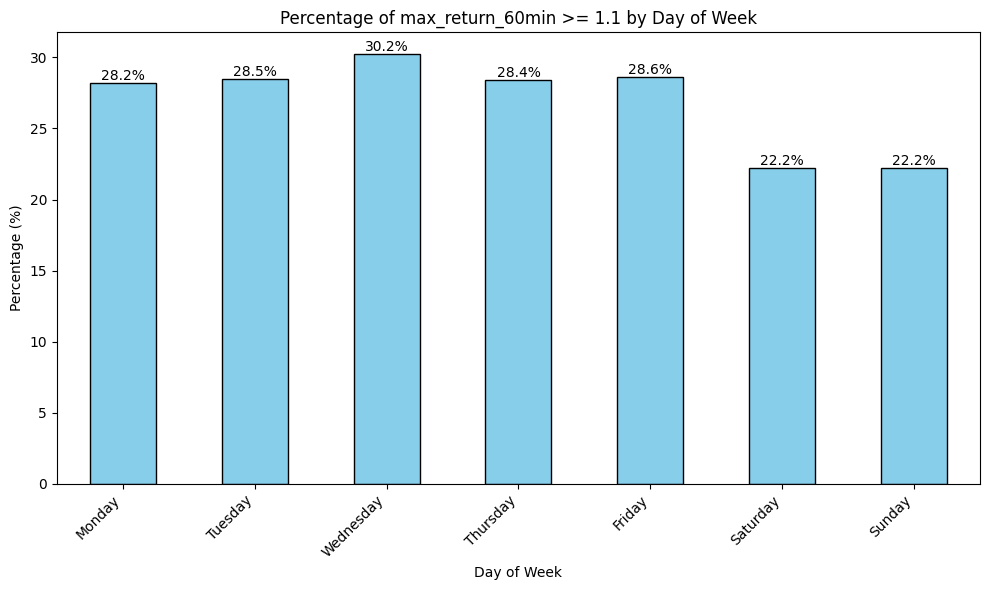

In [ ]:
# 요일 순서 정렬
ordered_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
results = results.reindex(ordered_days)

# 결과 출력
print(results)

# 시각화
fig, ax = plt.subplots(figsize=(10, 6))

# 막대 그래프 생성
results['percentage_above_1_1'].plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')

# 그래프 제목 및 축 레이블 설정
ax.set_title('Percentage of max_return_60min >= 1.1 by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Percentage (%)')
ax.set_xticklabels(ordered_days, rotation=45, ha='right')

# 값 레이블 추가
for i in ax.containers:
    ax.bar_label(i, fmt='%.1f%%')

# 그래프 출력
plt.tight_layout()
plt.show()

변동에 대한 최대 하락 구간의 분포

In [ ]:
pip install mplfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import mplfinance as mpf

In [ ]:
#메인 데이터
data = pd.read_csv("/kaggle/input/indicator3-full/SOL60_INDICATOR3")

# Display the first few rows of the dataset to ensure it is loaded correctly
data.head()

,Unnamed: 0.1,Unnamed: 0,open_time,open,high,low,close,volume,time,atr_5,...,price_ma_10,volume_ma_10,price_ma_20,volume_ma_20,price_ma_50,volume_ma_50,price_ma_100,volume_ma_100,price_ma_200,volume_ma_200
0,0,0,2020-12-31 15:00:00,1.4458,1.4458,1.4444,1.4456,161.34,15:00,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2020-12-31 15:01:00,1.4477,1.4478,1.4463,1.4463,148.86,15:01,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,2020-12-31 15:02:00,1.4479,1.4530,1.4466,1.4484,3208.13,15:02,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,2020-12-31 15:03:00,1.4503,1.4559,1.4503,1.4558,1639.76,15:03,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,2020-12-31 15:04:00,1.4558,1.4569,1.4545,1.4569,900.91,15:04,0.00404,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# 시간 관련 열 변환 함수
def convert_time_features(data):
    # open_time 열이 datetime 형식이 아닌 경우 변환
    if not np.issubdtype(data['open_time'].dtype, np.datetime64):
        data['open_time'] = pd.to_datetime(data['open_time'])

    # 요일 추출하여 data_day 변수에 저장
    data_day = data['open_time'].dt.day_name()

    # time 열을 분 단위로 변환
    data['time'] = data['open_time'].dt.hour * 60 + data['open_time'].dt.minute

    # 사용하지 않을 열 제외
    data = data.drop(columns=['open_time', 'Unnamed: 0', 'Unnamed: 0.1'])

    # 무한대 값을 NaN으로 대체
    data.replace([np.inf, -np.inf], np.nan, inplace=True)

    # NaN 값을 평균으로 대체
    imputer = SimpleImputer(strategy='mean')
    data_imputed = imputer.fit_transform(data)

    # numpy 배열을 다시 DataFrame으로 변환
    data = pd.DataFrame(data_imputed, columns=data.columns)

    data['day'] = data_day

    return data
# 시간 관련 열 변환
data = convert_time_features(data)

# 시간 변환 함수
def convert_time_to_hhmm(df, time_col='time'):
    # 분 단위를 시-분 형식으로 변환
    df['hhmm_time'] = pd.to_datetime(df[time_col], unit='m').dt.strftime('%H:%M')
    return df

# 시간 변환 함수 적용
data = convert_time_to_hhmm(data)

data.head()

NameError: name 'convert_time_to_datetime' is not defined

In [ ]:
data.head()

,open,high,low,close,volume,time,atr_5,atr_10,atr_14,atr_20,...,price_ma_20,volume_ma_20,price_ma_50,volume_ma_50,price_ma_100,volume_ma_100,price_ma_200,volume_ma_200,day,hhmm_time
0,1.4458,1.4458,1.4444,1.4456,161.34,900.0,0.00000,0.0,0.0,0.0,...,68.323751,3369.803441,68.323714,3369.844991,68.323652,3369.908842,68.32352,3370.005505,Thursday,15:00
1,1.4477,1.4478,1.4463,1.4463,148.86,901.0,0.00000,0.0,0.0,0.0,...,68.323751,3369.803441,68.323714,3369.844991,68.323652,3369.908842,68.32352,3370.005505,Thursday,15:01
2,1.4479,1.4530,1.4466,1.4484,3208.13,902.0,0.00000,0.0,0.0,0.0,...,68.323751,3369.803441,68.323714,3369.844991,68.323652,3369.908842,68.32352,3370.005505,Thursday,15:02
3,1.4503,1.4559,1.4503,1.4558,1639.76,903.0,0.00000,0.0,0.0,0.0,...,68.323751,3369.803441,68.323714,3369.844991,68.323652,3369.908842,68.32352,3370.005505,Thursday,15:03
4,1.4558,1.4569,1.4545,1.4569,900.91,904.0,0.00404,0.0,0.0,0.0,...,68.323751,3369.803441,68.323714,3369.844991,68.323652,3369.908842,68.32352,3370.005505,Thursday,15:04


In [ ]:
# max_return_60min이 1.1 이상인 데이터 필터링
filtered_data = data[data['max_return_60min'] >= 1.5]

# hhmm_time을 datetime 형식으로 변환
filtered_data['hhmm_time'] = pd.to_datetime(filtered_data['hhmm_time'], format='%H:%M')

# hhmm_time 열을 기준으로 그룹화하여 min_return_60min의 분포를 캔들 스틱으로 표시
candlestick_data = filtered_data.groupby(filtered_data['hhmm_time']).agg(
    Open=('min_return_60min', 'first'),
    High=('min_return_60min', 'max'),
    Low=('min_return_60min', 'min'),
    Close=('min_return_60min', 'last')
)

# 인덱스를 DatetimeIndex로 설정
candlestick_data.index = pd.to_datetime(candlestick_data.index)

# 캔들 스틱 차트 시각화
mpf.plot(candlestick_data, type='candle', style='charles', title='Candlestick chart of min_return_60min', ylabel='min_return_60min')

plt.show()

KeyError: 'hhmm_time'

In [ ]:
# max_return_60min과 min_return_60min 열을 마지막 부분으로 이동
columns = list(data.columns)
columns.remove('max_return_60min')
columns.remove('min_return_60min')
columns.extend(['max_return_60min', 'min_return_60min'])
data = data[columns]

In [ ]:
# max_return_60min이 1.1 이상이면서 min_return_60min이 1 이하인 데이터 필터링
filtered_data2 = data[(data['max_return_60min'] >= 1.5) & (data['min_return_60min'] <= -10)]

# 결과 출력
filtered_data2

,open,high,low,close,volume,time,atr_5,atr_10,atr_14,atr_20,...,price_ma_50,volume_ma_50,price_ma_100,volume_ma_100,price_ma_200,volume_ma_200,day,hhmm_time,max_return_60min,min_return_60min
9220,2.3600,2.4500,2.3456,2.3859,236991.83,40.0,0.059301,0.049312,0.043450,0.037168,...,2.042392,32118.7214,1.995326,19569.6597,1.987359,12386.61850,Thursday,00:40,2.213001,-10.650069
9752,2.2109,2.2296,2.2109,2.2296,12905.26,572.0,0.013562,0.015574,0.016879,0.018040,...,2.150404,11348.5174,2.114897,11966.8857,2.156705,7332.17020,Thursday,09:32,7.176175,-10.073556
9753,2.2256,2.2285,2.2211,2.2285,2576.58,573.0,0.012550,0.014866,0.016280,0.017563,...,2.153870,11377.7068,2.115603,11971.8557,2.156674,7343.87475,Thursday,09:33,7.229078,-10.029168
9754,2.2291,2.2400,2.2253,2.2392,24383.43,574.0,0.012980,0.014850,0.016167,0.017420,...,2.157656,11800.1768,2.116515,12132.2240,2.156693,7444.46840,Thursday,09:34,6.716685,-10.459093
9755,2.2399,2.3417,2.2351,2.3417,80776.56,575.0,0.031704,0.024025,0.022627,0.021879,...,2.163490,13317.3676,2.118558,12904.7167,2.157230,7843.01145,Thursday,09:35,2.045522,-14.378443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1725782,134.4600,135.5100,133.0100,133.0400,65397.78,1194.0,1.899186,1.333635,1.127868,0.963703,...,140.905000,12119.8830,141.201600,15248.3241,141.674450,16719.59865,Saturday,19:54,1.999399,-12.808178
1725784,134.7500,134.9000,130.0000,131.5900,93253.42,1196.0,2.627479,1.813245,1.501580,1.242992,...,140.528600,14378.0018,141.056100,16221.9375,141.533550,17296.18385,Saturday,19:56,2.386200,-11.847405
1725785,131.6000,133.7300,130.2300,131.4700,45905.76,1197.0,2.801983,1.981920,1.644325,1.355843,...,140.301400,15065.8750,140.961600,16503.6828,141.453650,17490.97645,Saturday,19:57,2.479653,-11.766943
1725786,131.5200,134.0500,131.5200,132.5100,34776.33,1198.0,2.757587,2.041728,1.711159,1.417051,...,140.097200,15577.8652,140.875800,16647.9330,141.379850,17631.74735,Saturday,19:58,1.675345,-12.459437


###########################Trailing Test######################


In [ ]:
#테스트 데이터 호출
data_test_tmp = pd.read_csv("/content/drive/MyDrive/Data/SOL_Data_Test_Indicator3.csv")

# Display the first few rows of the dataset to ensure it is loaded correctly
data_test_tmp.head()

,Unnamed: 0,open_time,open,high,low,close,volume,time,atr_5,atr_10,...,price_ma_20,volume_ma_20,price_ma_50,volume_ma_50,price_ma_100,volume_ma_100,price_ma_200,volume_ma_200,max_return_60min,min_return_60min
0,0,2023-07-26 15:00:00,24.49,24.53,24.49,24.53,4241.87,15:00,0.000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.916021,-0.122299
1,1,2023-07-26 15:01:00,24.53,24.57,24.53,24.55,5665.44,15:01,0.000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.832994,-0.203666
2,2,2023-07-26 15:02:00,24.55,24.59,24.54,24.57,3515.11,15:02,0.000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.750102,-0.284900
3,3,2023-07-26 15:03:00,24.58,24.58,24.53,24.53,2160.81,15:03,0.000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.916021,-0.122299
4,4,2023-07-26 15:04:00,24.53,24.55,24.52,24.53,2068.28,15:04,0.042,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.916021,-0.122299


In [ ]:
data_test = data_test_tmp
data_test.columns

Index(['Unnamed: 0', 'open_time', 'open', 'high', 'low', 'close', 'volume',
       'time', 'atr_5', 'atr_10',
       ...
       'price_ma_20', 'volume_ma_20', 'price_ma_50', 'volume_ma_50',
       'price_ma_100', 'volume_ma_100', 'price_ma_200', 'volume_ma_200',
       'max_return_60min', 'min_return_60min'],
      dtype='object', length=140)

In [ ]:
# open_time 열을 datetime 형식으로 변환
if not np.issubdtype(data_test['open_time'].dtype, np.datetime64):
    data_test['open_time'] = pd.to_datetime(data_test['open_time'])

# time 열을 분 단위로 변환
data_test['time'] = data_test['open_time'].dt.hour * 60 + data_test['open_time'].dt.minute

data_test = data_test.drop(columns=['Unnamed: 0'])

In [ ]:
# 사용하지 않을 열 제외
data_test_predict = data_test.drop(columns=['open_time', 'max_return_60min', 'min_return_60min'])

In [ ]:
# 사용하지 않을 열 제외 v2
# 피처 목록
features_to_keep = ['ichimoku_conversion_9', 'ichimoku_conversion_200', 'supertrend_upper_14_2_10',
                    'supertrend_upper_10_3_20', 'bollinger_hband_200', 'volume_ma_100', 'ROC_30',
                    'open', 'high', 'supertrend_lower_10_3_20', 'obv', 'atr_50', 'volume_ma_200',
                    'Accumulation_Distribution_Line', 'bollinger_lband_20', 'lowerband', 'volume_ma_20',
                    'supertrend_lower_7_3_14', 'atr_14', 'disparity_index_100', 'price_ma_200',
                    'bollinger_lband_50', 'ichimoku_conversion_52', 'upperband', 'atr_20', 'price_ma_20',
                    'disparity_index_20', 'time', 'vwap', 'bollinger_lband_200', 'atr_10', 'MFI_40',
                    'volume_ma_10', 'supertrend_in_uptrend_7_3_14', 'Momentum_30', 'Momentum_20',
                    'supertrend_upper_20_4_50', 'bollinger_hband_100', 'MFI_50', 'CMO_50', 'close',
                    'Momentum_50', 'stoch_%k_21_5', 'supertrend_upper_7_3_14', 'bollinger_hband_50',
                    'Parabolic_SAR_0.02', 'bollinger_lband_100', 'stoch_%k_9_3', 'Williams_%R_30', 'CMO_40']

# 피처들만 남기기
data_test_predict = data_test[features_to_keep]

In [ ]:
# 무한대 값을 NaN으로 대체
data_test_predict.replace([np.inf, -np.inf], np.nan, inplace=True)

# NaN 값을 평균으로 대체
imputer = SimpleImputer(strategy='mean')
data_test_predict_imputed = imputer.fit_transform(data_test_predict)  # 같은 imputer 사용

# 데이터 정규화
scaler = MinMaxScaler()
data_test_predict_scaled = scaler.fit_transform(data_test_predict_imputed)  # 같은 scaler 사용

<ipython-input-13-87e30df68ab5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test_predict.replace([np.inf, -np.inf], np.nan, inplace=True)


In [ ]:
#Transformer model 호출
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 모델 정의 (로드할 때 필요)
class TransformerEncoderModel(nn.Module):
    def __init__(self, input_dim, nhead, num_layers, dim_feedforward, output_dim):
        super(TransformerEncoderModel, self).__init__()
        self.embedding = nn.Linear(input_dim, input_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=nhead, dim_feedforward=dim_feedforward, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, src):
        src = self.embedding(src)
        output = self.transformer_encoder(src)
        output = self.fc(output[:, -1, :])  # Use the output from the last time step
        return output

In [ ]:
#Transformer model 호출2
# 시퀀스 길이 설정
sequence_length = 60

# 예측 데이터를 시퀀스 형태로 변환
def create_sequences_for_prediction(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        seq = data[i:i + sequence_length]
        sequences.append(seq)
    return np.array(sequences)

# 예측용 시퀀스 데이터 생성
X_test_seq = create_sequences_for_prediction(data_test_predict_scaled, sequence_length)

# 입력 차원 확인 및 설정
input_dim = X_test_seq.shape[2]
print(f"Input dimension: {input_dim}")

# 모델 설정 (로드할 때 필요)
nhead = 2
num_layers = 2
dim_feedforward = 64
output_dim = 1

model = TransformerEncoderModel(input_dim, nhead, num_layers, dim_feedforward, output_dim)

# 모델 로드
model_path = '/kaggle/input/lstm_indiactor3/pytorch/tcn_transformer/6/SOL60_SMALLL_INDICATOR3_Transformer_v3.pth'
model.load_state_dict(torch.load(model_path))
model.eval()
print(f"Model loaded from {model_path}")

In [ ]:
#TCN 모델 호출
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

#모델 로드
class TCNModel(nn.Module):
    def __init__(self, input_channels, num_channels, kernel_size=2, dropout=0.2):
        super(TCNModel, self).__init__()
        self.tcn = nn.Conv1d(input_channels, num_channels, kernel_size, padding=kernel_size//2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_channels, 1)

    def forward(self, x):
        x = x.transpose(1, 2)  # (batch_size, seq_len, input_channels) -> (batch_size, input_channels, seq_len)
        y1 = self.tcn(x)
        y1 = self.relu(y1)
        y1 = self.dropout(y1)
        y1 = y1[:, :, -1]
        o = self.fc(y1)
        return o

In [ ]:
#TCN 모델 호출2
# 시퀀스 길이 설정
sequence_length = 60

# 예측 데이터를 시퀀스 형태로 변환
def create_sequences_for_prediction(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        seq = data[i:i + sequence_length]
        sequences.append(seq)
    return np.array(sequences)

# 예측용 시퀀스 데이터 생성
X_test_seq = create_sequences_for_prediction(data_test_predict_scaled, sequence_length)

# 입력 차원 확인 및 설정
input_channels = X_test_seq.shape[2]
print(f"Input channels: {input_channels}")

# 모델 설정
num_channels = 64
model = TCNModel(input_channels, num_channels)

# 모델 로드
model_path = '/content/drive/MyDrive/Data/Model/SOL60_SMALLL_INDICATOR3_TCN_v5_60_06.pth'
model.load_state_dict(torch.load(model_path))
model.eval()
print(f"Model loaded from {model_path}")

Input channels: 50
Model loaded from /content/drive/MyDrive/Data/Model/SOL60_SMALLL_INDICATOR3_TCN_v5_60_06.pth


In [ ]:
# 슬라이딩 윈도우로 데이터 범위 추출
num_rows = data_test_predict_scaled.shape[0]

# 시퀀스 데이터를 텐서로 변환
X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
print(f"Tensor Transform Complete")

Tensor Transform Complete


In [ ]:
# 모델을 GPU로 이동 (가능한 경우)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
X_test_tensor = X_test_tensor.to(device)

In [ ]:
#prediction 결과 저장
results = []

#window_size = 216000
#window_size = 259200
window_size = 302400

batch_size = 64  # 배치 크기 설정

for end in tqdm(range(num_rows, window_size - 1, -batch_size)):
    start = max(end - batch_size + 1, 0)

    # 해당 범위에 대한 시퀀스 텐서 추출
    X_test_tensor_tmp = X_test_tensor[start:end]

    # 예측 수행
    model.eval()
    with torch.no_grad():
        predictions = torch.sigmoid(model(X_test_tensor_tmp)).squeeze().cpu().numpy()

    # 예측 결과를 이진 분류로 변환 (0 또는 1)
    predictions = (predictions > 0.5).astype(int)

    # 예측 결과의 마지막 값을 추가
    if len(predictions.shape) > 0:
        results.append(predictions[-1])
    else:
        results.append(predictions)

results = results[::-1]  # 원래 순서대로 변경

100%|██████████| 3511/3511 [00:03<00:00, 908.09it/s]


In [ ]:
# 결과를 원본 데이터프레임에 추가
data_test['Predictions'] = np.nan
data_test.loc[data_test.index[-len(results):], 'Predictions'] = results
data_test = data_test.dropna(subset=['Predictions'])

In [ ]:
# 'max_return_60min' 값이 1 이상이고 'prediction' 값이 0인 데이터의 개수
count_max_return_ge_1_prediction_0 = len(data_test[(data_test['max_return_60min'] >= 1.1) & (data_test['Predictions'] == 1)])

# 'max_return_60min' 값이 1 미만이고 'prediction' 값이 1인 데이터의 개수
count_max_return_lt_1_prediction_1 = len(data_test[(data_test['max_return_60min'] < 1.1) & (data_test['Predictions'] == 0)])

#
print(f"max_return_60min이 1 이상인데 prediction이 0인 데이터의 비율: {count_max_return_ge_1_prediction_0/len(data_test)*100}")
print(f"max_return_60min이 1 미만인데 prediction이 1인 데이터의 비율: {count_max_return_lt_1_prediction_1/len(data_test)*100}")

max_return_60min이 1 이상인데 prediction이 0인 데이터의 비율: 28.026203360865846
max_return_60min이 1 미만인데 prediction이 1인 데이터의 비율: 19.880375961264598


In [ ]:
# 시간대를 나타내는 새로운 열 추가 (30분 단위)
data_test['half_hour'] = data_test['open_time'].dt.floor('30T').dt.time

# 시간대별로 데이터 그룹화 (30분 단위)
grouped = data_test.groupby('half_hour')

# 각 시간대별로 조건을 만족하는 데이터의 개수를 계산하는 함수
def calculate_counts(group):
    count_max_return_ge_1_prediction_0 = len(group[(group['max_return_60min'] >= 1.1) & (group['Predictions'] == 1)])
    count_max_return_lt_1_prediction_1 = len(group[(group['max_return_60min'] < 1.1) & (group['Predictions'] == 0)])

    total_count = len(group)

    if total_count == 0:
        return pd.Series([0, 0, 0, 0, 0])

    rate_max_return_ge_1_prediction_0 = (count_max_return_ge_1_prediction_0 / total_count) * 100
    rate_max_return_lt_1_prediction_1 = (count_max_return_lt_1_prediction_1 / total_count) * 100

    total_rate = rate_max_return_ge_1_prediction_0 + rate_max_return_lt_1_prediction_1

    return pd.Series([count_max_return_ge_1_prediction_0, count_max_return_lt_1_prediction_1, rate_max_return_ge_1_prediction_0, rate_max_return_lt_1_prediction_1, total_rate])

# 각 그룹에 함수 적용
results = grouped.apply(calculate_counts)
results.columns = ['Count_GE_1_Pred_0', 'Count_LT_1_Pred_1', 'Rate_GE_1_Pred_0', 'Rate_LT_1_Pred_1', 'Total_Rate']

# 결과 출력
print(results)

In [ ]:
# 시간대를 UTC 및 KST로 표시
results['half_hour_utc'] = pd.to_datetime(results.index.astype(str), format='%H:%M:%S').time
results['half_hour_kst'] = (pd.to_datetime(results.index.astype(str), format='%H:%M:%S') + pd.Timedelta(hours=9)).time
results['half_hour_label'] = results.index.astype(str) + ' (' + results['half_hour_kst'].astype(str) + ' KST)'

# x축을 시간으로, y축을 Total_Rate으로 하는 차트 그리기
plt.figure(figsize=(12, 6))
plt.plot(results['half_hour_label'], results['Total_Rate'], marker='o')
plt.xlabel('Half Hour of the Day (UTC)')
plt.ylabel('Total Rate (%)')
plt.title('Total Rate of Conditions Met by Half Hour of the Day (UTC with KST)')
plt.grid(True)
plt.xticks(rotation=45, ha='right')  # 레이블을 오른쪽으로 회전하여 수평으로 정렬

# y축 90 라인 진하게 표시
plt.axhline(90, color='red', linewidth=1.5, linestyle='--')  # y=90 라인을 진하게

plt.show()

Auto_Modeling_Test

In [ ]:
pip install joblib

In [ ]:
pip install tdqm

In [ ]:
import numpy as np
import pandas as pd
import joblib
from tqdm import tqdm

# TensorFlow 및 TPU 설정
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
#데이터 호출 시리즈
Data_list = ["/kaggle/input/data-set-24-08-09/SOL_Data_1m_Micro_Indicator3.csv",
             "/kaggle/input/data-set-24-08-09/SOL_Data_3m_Micro_Indicator3.csv",
             "/kaggle/input/data-set-24-08-09/SOL_Data_5m_Micro_Indicator3.csv",
             "/kaggle/input/data-set-24-08-09/SOL_Data_15m_Micro_Indicator3.csv"
             "/kaggle/input/data-set-24-08-09/SOL_Data_30m_Micro_Indicator3.csv"]

Data_save = ["/kaggle/working/SOL_Data_1m_Micro_INDICATOR3_TCN_v4.pth",
             "/kaggle/working/SOL_Data_3m_Micro_INDICATOR3_TCN_v4.pth",
             "/kaggle/working/SOL_Data_5m_Micro_INDICATOR3_TCN_v4.pth",
             "/kaggle/working/SOL_Data_15m_Micro_INDICATOR3_TCN_v4.pth"
             "/kaggle/working/SOL_Data_30m_Micro_INDICATOR3_TCN_v4.pth"]

Data_Test_list = ["/kaggle/input/data-set-24-08-09/SOL_Data_Test_1m_Indicator3.csv",
                  "/kaggle/input/data-set-24-08-09/SOL_Data_Test_3m_Indicator3.csv",
                  "/kaggle/input/data-set-24-08-09/SOL_Data_Test_5m_Indicator3.csv",
                  "/kaggle/input/data-set-24-08-09/SOL_Data_Test_15m_Indicator3.csv"
                  "/kaggle/input/data-set-24-08-09/SOL_Data_Test_30m_Indicator3.csv"]

Target_List = [0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1]

mention_List = ["1m", "3m", "5m", "15m", "30m"]

In [ ]:
#함수 시리즈

def drop_unnamed_column(df):
    # 'Unnamed: 0' 열이 존재하는지 확인
    if 'Unnamed: 0' in df.columns:
        # 존재한다면 해당 열 삭제
        df = df.drop(columns=['Unnamed: 0'])
    return df

# 시간 관련 열 변환 함수
def convert_time_features(data):
    # open_time 열이 datetime 형식이 아닌 경우 변환
    if not np.issubdtype(data['open_time'].dtype, np.datetime64):
        data['open_time'] = pd.to_datetime(data['open_time'])

    # time 열을 분 단위로 변환
    data['time'] = data['open_time'].dt.hour * 60 + data['open_time'].dt.minute

    # 사용하지 않을 열 제외
    data = data.drop(columns=['open_time'])

    return data

# 데이터 전처리 함수
def preprocess_data(data, point):
    # 목표 변수 생성
    data['target'] = (data['max_return_60min'] >= point).astype(int)

    # 특성과 목표 변수 분리
    X = data.drop(columns=['max_return_60min', 'min_return_60min', 'target'])
    y = data['target']

    # 무한대 값을 NaN으로 대체
    X.replace([np.inf, -np.inf], np.nan, inplace=True)

    # NaN 값을 평균으로 대체
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)

    # 데이터 정규화
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_imputed)

    return X_scaled, y

# 시계열 데이터 형태로 변환 함수
def create_sequences(data, target, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length + 1):
        seq = data[i:i + sequence_length]
        label = target[i + sequence_length - 1]
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)

# 예측 데이터를 시퀀스 형태로 변환
def create_sequences_for_prediction(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        seq = data[i:i + sequence_length]
        sequences.append(seq)
    return np.array(sequences)

# TCN 모델 정의
class TCNModel(nn.Module):
    def __init__(self, input_size, num_channels, kernel_size=2, dropout=0.2):
        super(TCNModel, self).__init__()
        self.tcn = nn.Conv1d(input_size, num_channels, kernel_size, padding=kernel_size//2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_channels, 1)

    def forward(self, x):
        x = x.transpose(1, 2)  # (batch_size, seq_len, input_size) -> (batch_size, input_size, seq_len)
        y1 = self.tcn(x)
        y1 = self.relu(y1)
        y1 = self.dropout(y1)
        y1 = y1[:, :, -1]
        o = self.fc(y1)
        return o

In [ ]:
for idx in range(5) :

  print(f"---------START({mention_List[idx]})------------")

  # 테스트 데이터 호출
  data_test = pd.read_csv(Data_Test_list[idx])

  # 테스트 데이터 시간 관련 열 변환
  data_test = convert_time_features(data_test)

  # 테스트 데이터 사용하지 않을 열 제외
  data_test_predict = data_test.drop(columns=['max_return_60min', 'min_return_60min'])

  # 테스트 데이터 무한대 값을 NaN으로 대체
  data_test_predict.replace([np.inf, -np.inf], np.nan, inplace=True)

  # 테스트 데이터 NaN 값을 평균으로 대체
  imputer = SimpleImputer(strategy='mean')
  data_test_predict_imputed = imputer.fit_transform(data_test_predict)  # 같은 imputer 사용

  # 테스트 데이터 데이터 정규화
  scaler = MinMaxScaler()
  data_test_predict_scaled = scaler.fit_transform(data_test_predict_imputed)  # 같은 scaler 사용

  # 데이터 호출
  data = pd.read_csv(Data_list[idx])

  # 시간 관련 열 변환
  data = convert_time_features(data)

  # 시퀀스 길이 설정
  sequence_length = 60

  # 예측용 시퀀스 데이터 생성
  X_test_seq = create_sequences_for_prediction(data_test_predict_scaled, sequence_length)

  #목표 수익
  percent_point = Target_List[idx]

  for idx2 in range(8) :
    #목표 수익
    percent_point = Target_List[idx2]

    #Unnamed: 0 열 제거
    data_test = drop_unnamed_column(data_test)

    # 데이터 전처리
    X_scaled, y = preprocess_data(data, percent_point)

    # 데이터 길이 체크
    if len(X_scaled) < sequence_length:
        raise ValueError(f"데이터 길이({len(X_scaled)})가 시퀀스 길이({sequence_length})보다 짧습니다.")

    # 시퀀스 데이터 생성
    y_array = y.values  # pandas Series를 numpy array로 변환
    X_seq, y_seq = create_sequences(X_scaled, y_array, sequence_length)

    # 학습 데이터와 검증 데이터 분리
    X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

    # 데이터를 텐서로 변환
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    # 데이터 로더 생성
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # 모델 설정
    input_size = X_train.shape[2]
    num_channels = 64
    model = TCNModel(input_size, num_channels)

    # 손실 함수 및 옵티마이저 설정
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 조기 종료 설정
    patience = 5
    best_loss = float('inf')
    patience_counter = 0

    # 학습 및 검증 손실을 저장할 리스트
    train_losses = []
    val_losses = []

    # 학습
    num_epochs = 5  # 최대 에포크 수
    for epoch in range(num_epochs):
        # 학습 단계
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # 검증 단계
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                output = model(X_batch)
                loss = criterion(output, y_batch)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

        # 조기 종료 조건 체크
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("조기 종료 조건 충족. 학습을 중지합니다.")
            break

    # 모델 평가
    model.eval()
    with torch.no_grad():
      y_true = []
      y_pred = []
      for X_batch, y_batch in test_loader:
        output = model(X_batch)
        y_true.extend(y_batch.tolist())
        y_pred.extend(torch.sigmoid(output).squeeze().tolist())

    # 이진 분류 결과를 위한 평가 지표 계산
    y_pred = np.array(y_pred) > 0.5
    y_true = y_test_tensor.numpy()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # 모델 상태 저장
    torch.save(model.state_dict(), Data_save[idx])

    # 슬라이딩 윈도우로 데이터 범위 추출
    num_rows = data_test_predict_scaled.shape[0]

    # 시퀀스 데이터를 텐서로 변환
    X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)

    # 모델을 GPU로 이동 (가능한 경우)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    X_test_tensor = X_test_tensor.to(device)

    window_size = [216000, 259200, 302400]

    #prediction 결과 저장
    results = []

    # 배치 크기 설정
    batch_size = 63

    for idx_window in range(3) :

      #prediction 결과 저장
      results = []

      for end in tqdm(range(num_rows, window_size[idx_window] - 1, -batch_size)):
          start = max(end - batch_size + 1, 0)

          # 해당 범위에 대한 시퀀스 텐서 추출
          X_test_tensor_tmp = X_test_tensor[start:end]

          # 예측 수행
          model.eval()
          with torch.no_grad():
              predictions = torch.sigmoid(model(X_test_tensor_tmp)).squeeze().cpu().numpy()

          # 예측 결과를 이진 분류로 변환 (0 또는 1)
          predictions = (predictions > 0.5).astype(int)

          # 예측 결과의 마지막 값을 추가
          if len(predictions.shape) > 0:
              results.append(predictions[-1])
          else:
              results.append(predictions)

      # 원래 순서대로 변경
      results = results[::-1]  # 원래 순서대로 변경

      data_test['Predictions'] = np.nan
      data_test.loc[data_test.index[-len(results):], 'Predictions'] = results
      data_test = data_test.dropna(subset=['Predictions'])

      # 'max_return_60min' 값이 1 이상이고 'prediction' 값이 0인 데이터의 개수
      count_max_return_ge_1_prediction_0 = len(data_test[(data_test['max_return_60min'] >= 1.1) & (data_test['Predictions'] == 1)])

      # 'max_return_60min' 값이 1 미만이고 'prediction' 값이 1인 데이터의 개수
      count_max_return_lt_1_prediction_1 = len(data_test[(data_test['max_return_60min'] < 1.1) & (data_test['Predictions'] == 0)])

      #
      tmp1 = count_max_return_ge_1_prediction_0/len(data_test)*100
      tmp2 = count_max_return_lt_1_prediction_1/len(data_test)*100
      #
      print(f"[max_return_60min/{mention_List[idx]}/{percent_point}이상/1/{window_size[idx_window]}] : {tmp1}")
      print(f"[max_return_60min/{mention_List[idx]}/{percent_point}미만/0{window_size[idx_window]}] : {tmp2}")
      print(f"[확률/{mention_List[idx]}/{percent_point}/{window_size[idx_window]}] : {tmp1 + tmp2}")


  print(f"---------END({mention_List[idx]})------------")
